<a href="https://colab.research.google.com/github/nathanielkang/yonsei_research/blob/main/ICT_TimeSeries_Kang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up

*For users who want to utilize virtual machine:
Switch the backend into either GPU or TPU to run complex computations in an efficient manner*

In [ ]:
# https://analyticsindiamag.com/explained-how-to-access-jupyterlab-on-google-colab/
!pip install colabcode

In [ ]:
import colabcode as cc

cc.ColabCode(port = 10000,  lab = True)

The raw data has been cleaned and saved as two files - monthly files, which contains the independent variables. And another file is quarter file - ICT-GDP is the dependent variable that we are trying to predict.


In [80]:
import os 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Packages and Libraries

In [81]:
ls

 code/   data/  'ICT Time Seires.ipynb'   login.txt   output/


In [82]:
!pip install statsmodels #we will heavily use statsmodels for data visualization

In [83]:
!pip install statsmodels --upgrade

In [84]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import pandas as pd
import json
import datetime as dt
import pandas as pd
import os
import warnings
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import all modules related to visualization
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use('Solarize_Light2')
# import all modules related to statistical computing
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [158]:
import statsmodels.robust

In [85]:
# filter warnings
warnings.filterwarnings("ignore")

## Load Data

**Dependent Variable:**

*   ICT_GDP (단위: 십억원)


**Predictors:**

*   Export 정보통신방송기기 수출(달러)
*   ICT_index ICT생산지수
*   ship_index 생산자제품 출하지수(원지수)
*   invetory_index 생산자제품 재고지수(원지수)
*   service 정보통신업 서비스 산업생산


In [86]:
ls

 code/   data/  'ICT Time Seires.ipynb'   login.txt   output/


In [87]:
%cd drive/My Drive/Research

[Errno 2] No such file or directory: 'drive/My Drive/Research'
/content/drive/My Drive/Research


In [174]:
# read in all the csv-files
# all data downloaded from the Federal-Reserve-Economic-Data (FRED) website

path = os.getcwd() + "/data"
files = glob.glob(os.path.join(path, "*.csv"))
file_list = list()
for f in files:
    df = pd.read_csv(f)
    file_list.append(df)

In [175]:
# set the date as index and select range of dates
for i in range(len(file_list)):
    file_list[i]["Date"] = pd.to_datetime(file_list[i]["Date"])
    file_list[i].set_index("Date", inplace = True)
    file_list[i] = file_list[i]["2000-01-01":"2020-10-01"]

In [176]:
df = pd.concat(file_list, axis = 1).dropna()

In [177]:
df.head()

,ICT_GDP,Export,ICT_index,ship_index,invetory_index,service
Date,,,,,,
2000-01-01,14976.3,3262605944,17.634,21.444,12.902,44.0
2000-02-01,14976.3,3265148829,17.017,20.919,12.640,44.2
2000-03-01,14976.3,3966574126,19.019,23.362,14.246,47.9
2000-04-01,15882.9,3623607673,18.756,22.604,12.818,45.1
2000-05-01,15882.9,3646771250,19.124,22.910,13.920,47.9


In [184]:
df = pd.concat(file_list, axis = 1).dropna()
df.columns = ["ICT_GDP", "EXPORT", "ICT_INDEX", "SHIP_INDEX" ,"INVENT_INDEX", "SERVICE"]
print(df)

            ICT_GDP      EXPORT  ICT_INDEX  SHIP_INDEX  INVENT_INDEX  SERVICE
Date                                                                         
2000-01-01  14976.3  3262605944     17.634      21.444        12.902     44.0
2000-02-01  14976.3  3265148829     17.017      20.919        12.640     44.2
2000-03-01  14976.3  3966574126     19.019      23.362        14.246     47.9
2000-04-01  15882.9  3623607673     18.756      22.604        12.818     45.1
2000-05-01  15882.9  3646771250     19.124      22.910        13.920     47.9
...             ...         ...        ...         ...           ...      ...
2020-05-01  52829.3  8925390493    139.200     107.800        94.100    110.0
2020-06-01  52829.3  8978383271    151.000     122.400        90.400    118.1
2020-07-01  57977.9  9855282053    144.800     109.600       103.800    111.8
2020-08-01  57977.9  9197736440    152.100     122.900       108.500    109.6
2020-09-01  57977.9  9565166261    164.200     145.100        88

# 2. Explore the raw data

In [178]:
# function for visualization of the data
def graph_plot(data, name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5))
    
    # plot the original series
    ax1.plot(data, color = "darkblue", label = name)
    # estimated trend using a hodrick-prescott filter
    ax1.plot(hpfilter(data, 1600)[1], color = "green", linewidth = 1, label = r"Hodrick-Prescott Filter ($\lambda = 1600$)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel(name)
    ax1.set_title(name, loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)
    
    # plot the growth rates of the series
    ax2.plot(data.pct_change(), color = "darkblue")
    ax2.set_xlabel("Date")
    ax2.set_title(name + " (percent change)", loc = "left")
    ax2.axhline(y = 0, color = "red", linestyle = "--")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # layout optimization
    plt.tight_layout()

**Smoothing technique:**

The Hodrick-Prescott (HP) filter refers to a data-smoothing technique. The HP filter is commonly applied during analysis to remove short-term fluctuations associated with the business cycle. Removal of these short-term fluctuations reveals long-term trends

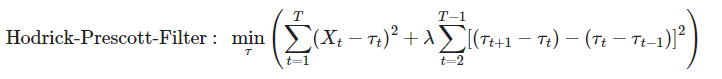

### Variables

In [183]:
df.columns

Index(['ICT_GDP', 'Export', 'ICT_index', 'ship_index', 'invetory_index',
       'service'],
      dtype='object')

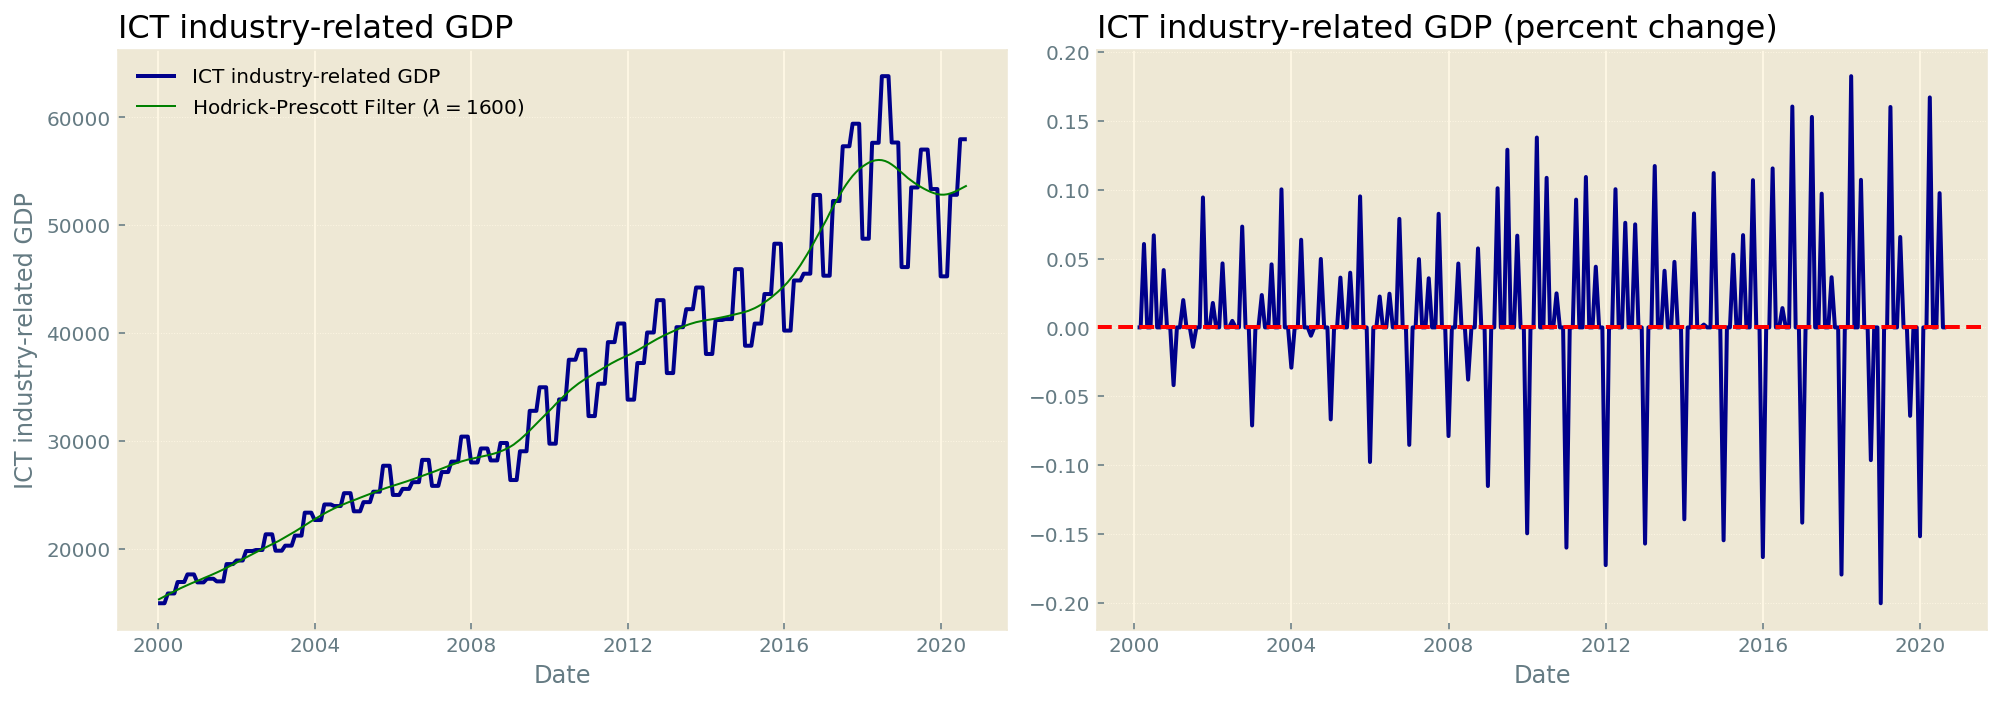

In [180]:
graph_plot(df["ICT_GDP"], "ICT industry-related GDP")


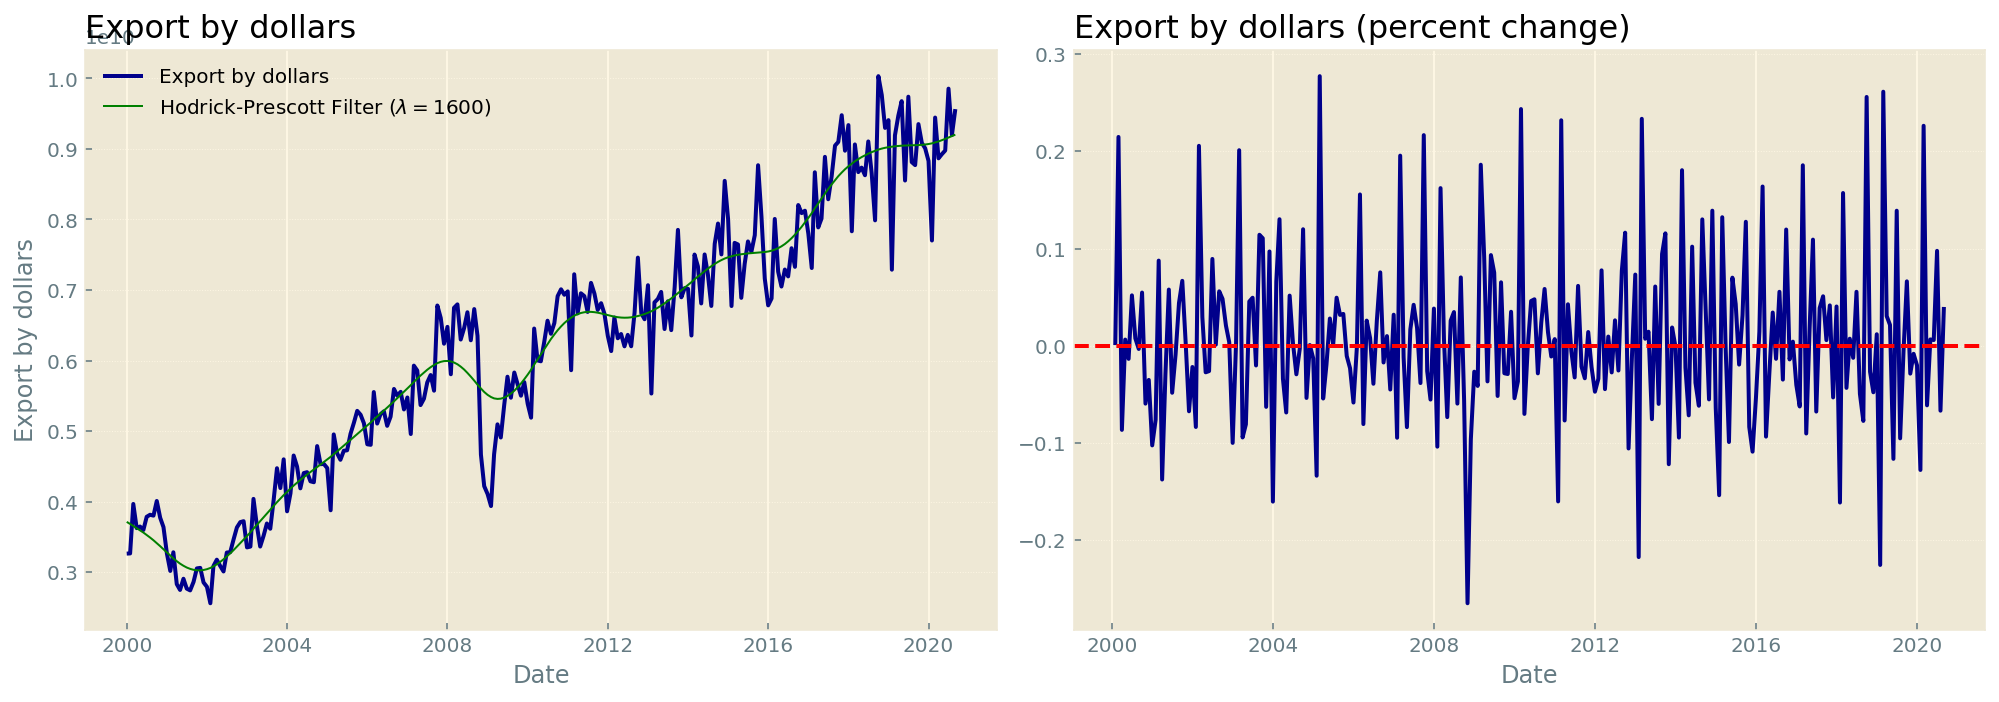

In [185]:
graph_plot(df["EXPORT"], "Export by dollars")

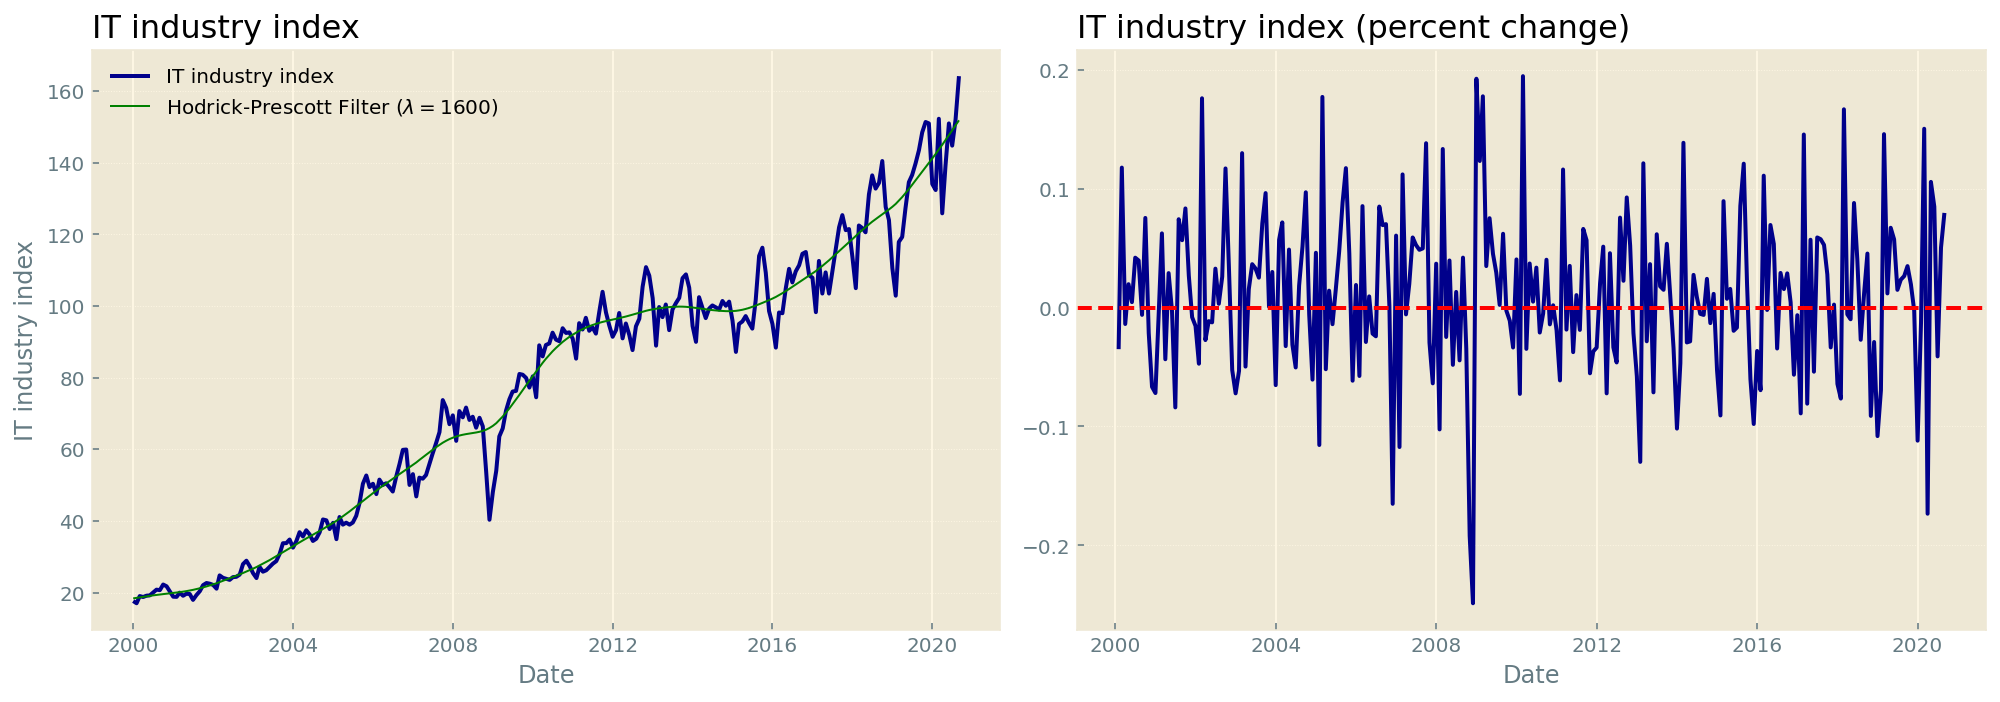

In [186]:
graph_plot(df["ICT_INDEX"], "IT industry index")

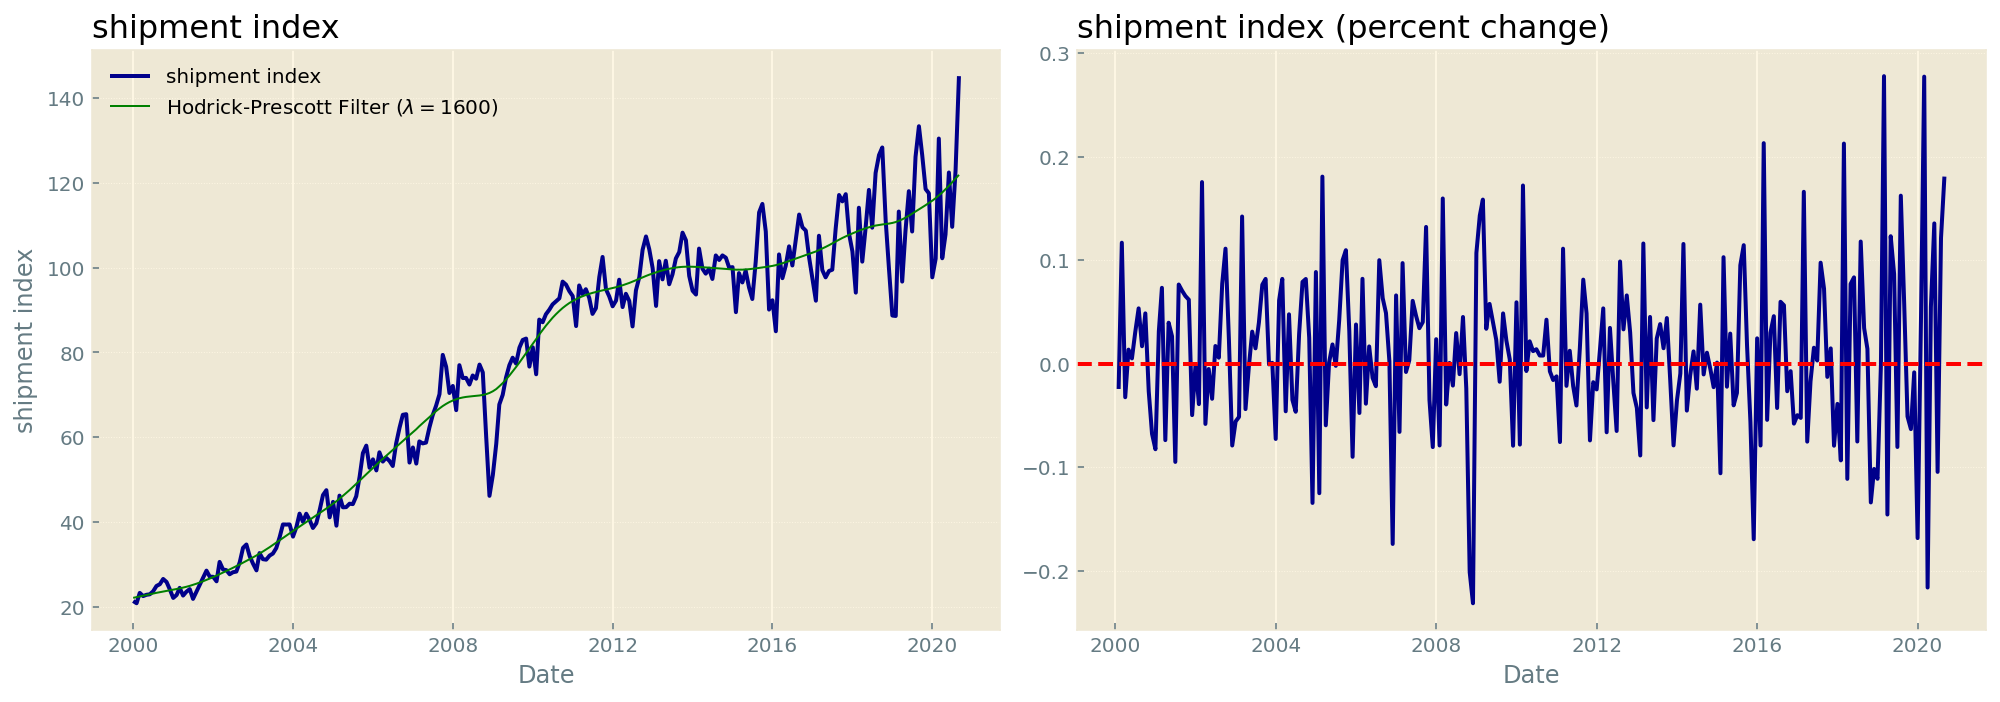

In [187]:
graph_plot(df["SHIP_INDEX"], "shipment index")

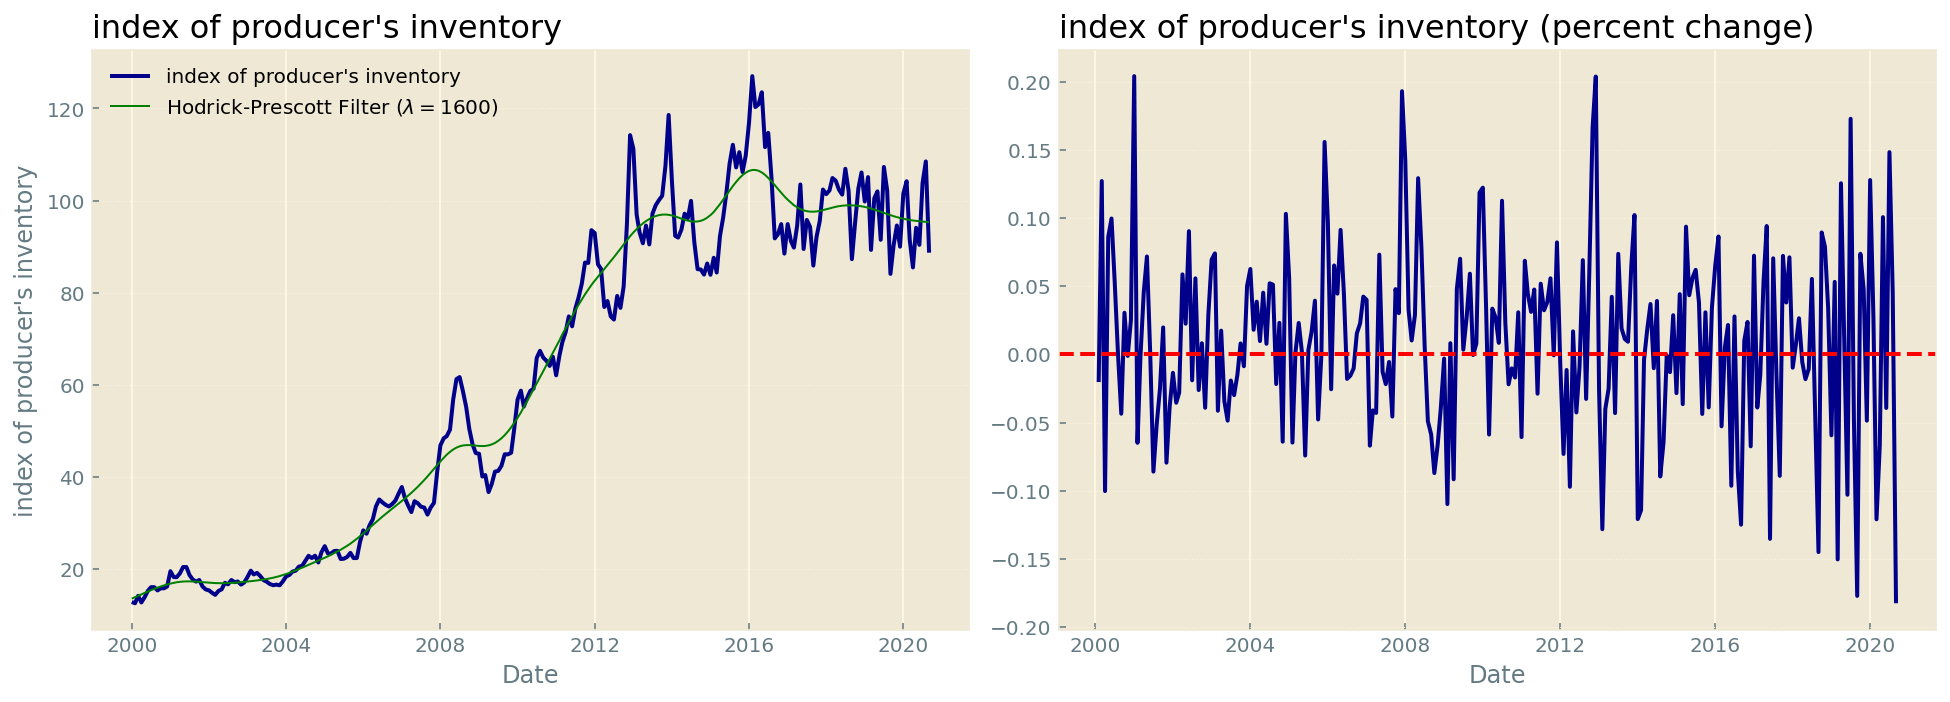

In [188]:
graph_plot(df["INVENT_INDEX"], "index of producer's inventory")

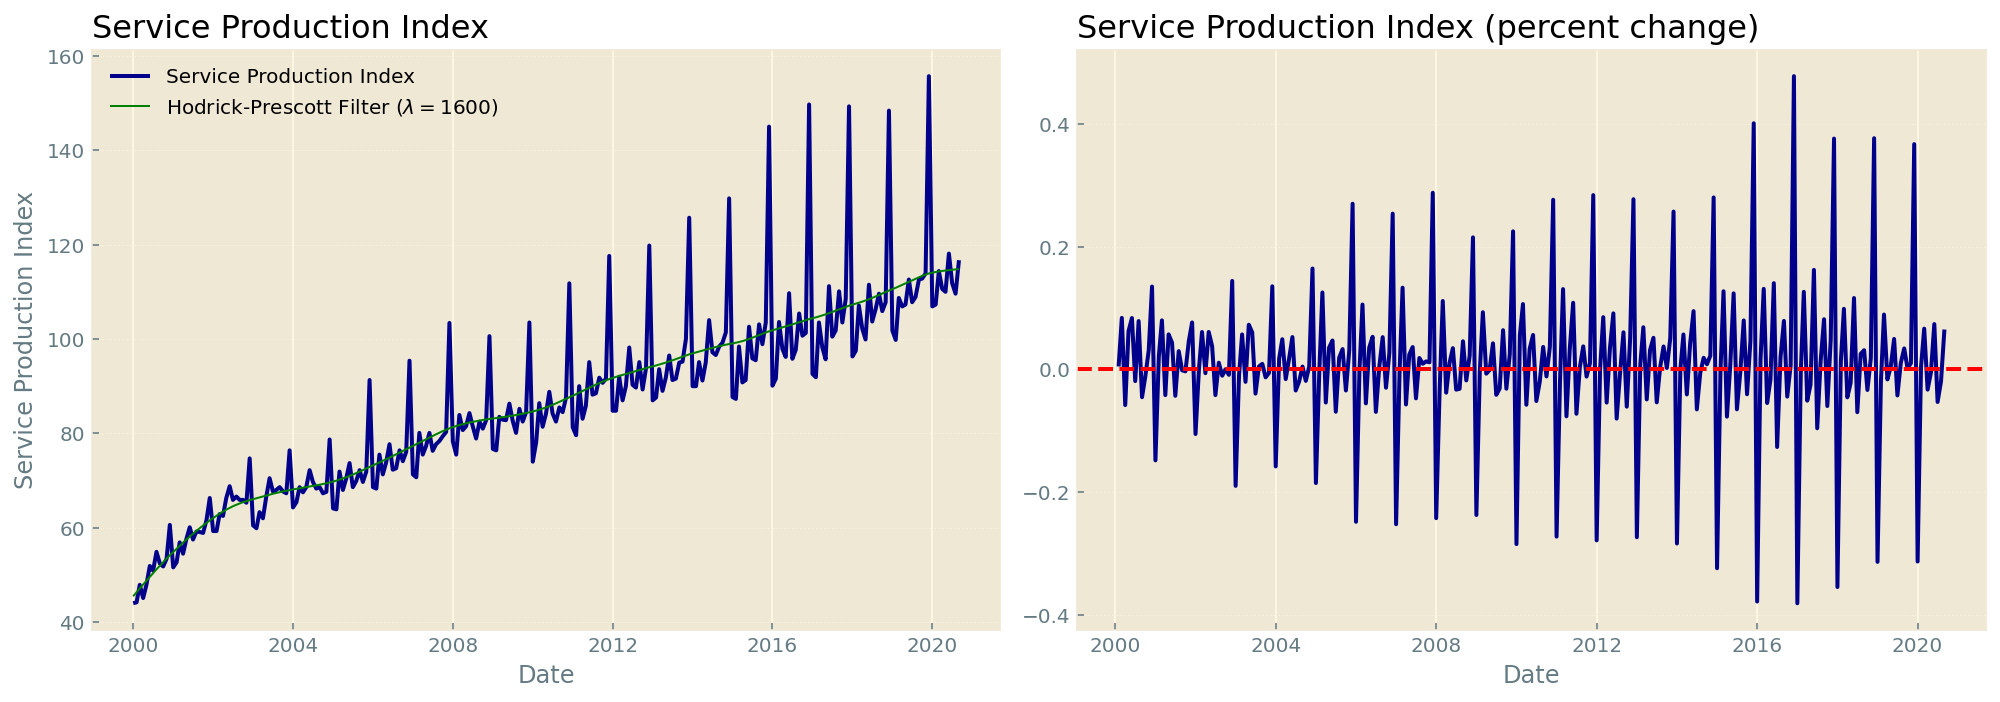

In [189]:
graph_plot(df["SERVICE"], "Service Production Index")

In [190]:
# continue analysis with growth rates
for column in df:
    if column != "SERVICE":
        df[column] = df[column].pct_change() * 100
    else:
        df[column] = df[column].pct_change() * 10
df.dropna(inplace = True)
df = df.round(2)
print(df)

            ICT_GDP  EXPORT  ICT_INDEX  SHIP_INDEX  INVENT_INDEX  SERVICE
Date                                                                     
2000-02-01     0.00    0.08      -3.50       -2.45         -2.03     0.05
2000-03-01     0.00   21.48      11.76       11.68         12.71     0.84
2000-04-01     6.05   -8.65      -1.38       -3.24        -10.02    -0.58
2000-05-01     0.00    0.64       1.96        1.35          8.60     0.62
2000-06-01     0.00   -1.34       0.45        0.50          9.96     0.84
...             ...     ...        ...         ...           ...      ...
2020-05-01     0.00    0.66      10.56        5.48         10.06    -0.05
2020-06-01     0.00    0.59       8.48       13.54         -3.93     0.74
2020-07-01     9.75    9.77      -4.11      -10.46         14.82    -0.53
2020-08-01     0.00   -6.67       5.04       12.14          4.53    -0.20
2020-09-01     0.00    3.99       7.96       18.06        -18.25     0.65

[248 rows x 6 columns]


### Stationarity

In [191]:
# ADF test
# null hypothesis : series not stationary (unit root)
# alternate hypothesis : series is stationary
# reject null hypothesis if p-value <= 0.05
def adf_test(data):
    d = 0
    # run ADF test on 1% significance level
    adf_test = adfuller(data.dropna())
    test_statistic,  p_value, crit_value = adf_test[0], adf_test[1], adf_test[4]["1%"]
    while test_statistic > crit_value:
        data = data.diff()
        adf_test = adfuller(data.dropna())
        test_statistic,  p_value, crit_value = adf_test[0], adf_test[1], adf_test[4]["1%"]
        # set order of differencing required for stationarity
        d = d + 1
    # return test results
    return test_statistic, p_value, crit_value, d

In [192]:
# run the hypothesis test on the data 
adf_results = pd.DataFrame(columns = ["t-value", "p-value", "c-value", "d"], 
                       index = ["ICT_GDP", "EXPORT","ICT_INDEX", "SHIP_INDEX", "INVENT_INDEX", "SERVICE"])
for column in df:
    adf_results.loc[column] = adf_test(df[column])

In [193]:
# print results
adf_results = adf_results.astype(float).round(2)
print(adf_results)

              t-value  p-value  c-value    d
ICT_GDP         -4.14      0.0    -3.46  0.0
EXPORT          -5.44      0.0    -3.46  0.0
ICT_INDEX       -5.38      0.0    -3.46  0.0
SHIP_INDEX      -4.41      0.0    -3.46  0.0
INVENT_INDEX    -6.54      0.0    -3.46  0.0
SERVICE        -14.09      0.0    -3.46  1.0


In [194]:
# difference the data for each indicator if necessary
for i, value in enumerate(adf_results["d"]):
    j = 0
    while j != value:
        df[adf_results.index[i]] = df[adf_results.index[i]].diff()
        j = j + 1
df.dropna(inplace = True)
print(df)

            ICT_GDP  EXPORT  ICT_INDEX  SHIP_INDEX  INVENT_INDEX  SERVICE
Date                                                                     
2000-03-01     0.00   21.48      11.76       11.68         12.71     0.79
2000-04-01     6.05   -8.65      -1.38       -3.24        -10.02    -1.42
2000-05-01     0.00    0.64       1.96        1.35          8.60     1.20
2000-06-01     0.00   -1.34       0.45        0.50          9.96     0.22
2000-07-01     6.68    5.19       4.19        3.02          5.32    -1.03
...             ...     ...        ...         ...           ...      ...
2020-05-01     0.00    0.66      10.56        5.48         10.06     0.28
2020-06-01     0.00    0.59       8.48       13.54         -3.93     0.79
2020-07-01     9.75    9.77      -4.11      -10.46         14.82    -1.27
2020-08-01     0.00   -6.67       5.04       12.14          4.53     0.33
2020-09-01     0.00    3.99       7.96       18.06        -18.25     0.85

[247 rows x 6 columns]


### Autocorrelation

In [195]:
# function for visualization of the autocorrelation
def acf_plot(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5))
        
    # compute acf values and plot them
    plot_acf(data, ax = ax1, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax1.axhline(y = 2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax1.axhline(y = -2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax1.set_title("Autocorrelation Function", loc = "left")
    ax1.set_xlabel("Lags")
    ax1.set_ylabel("Autocorrelation")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # compute pacf values and plot them
    plot_pacf(data, ax = ax2, title = "", zero = False, color = "darkblue", 
              alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.axhline(y = 2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax2.set_title("Partial Autocorrelation Function", loc = "left")
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Partial Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # layout optimization
    plt.tight_layout()

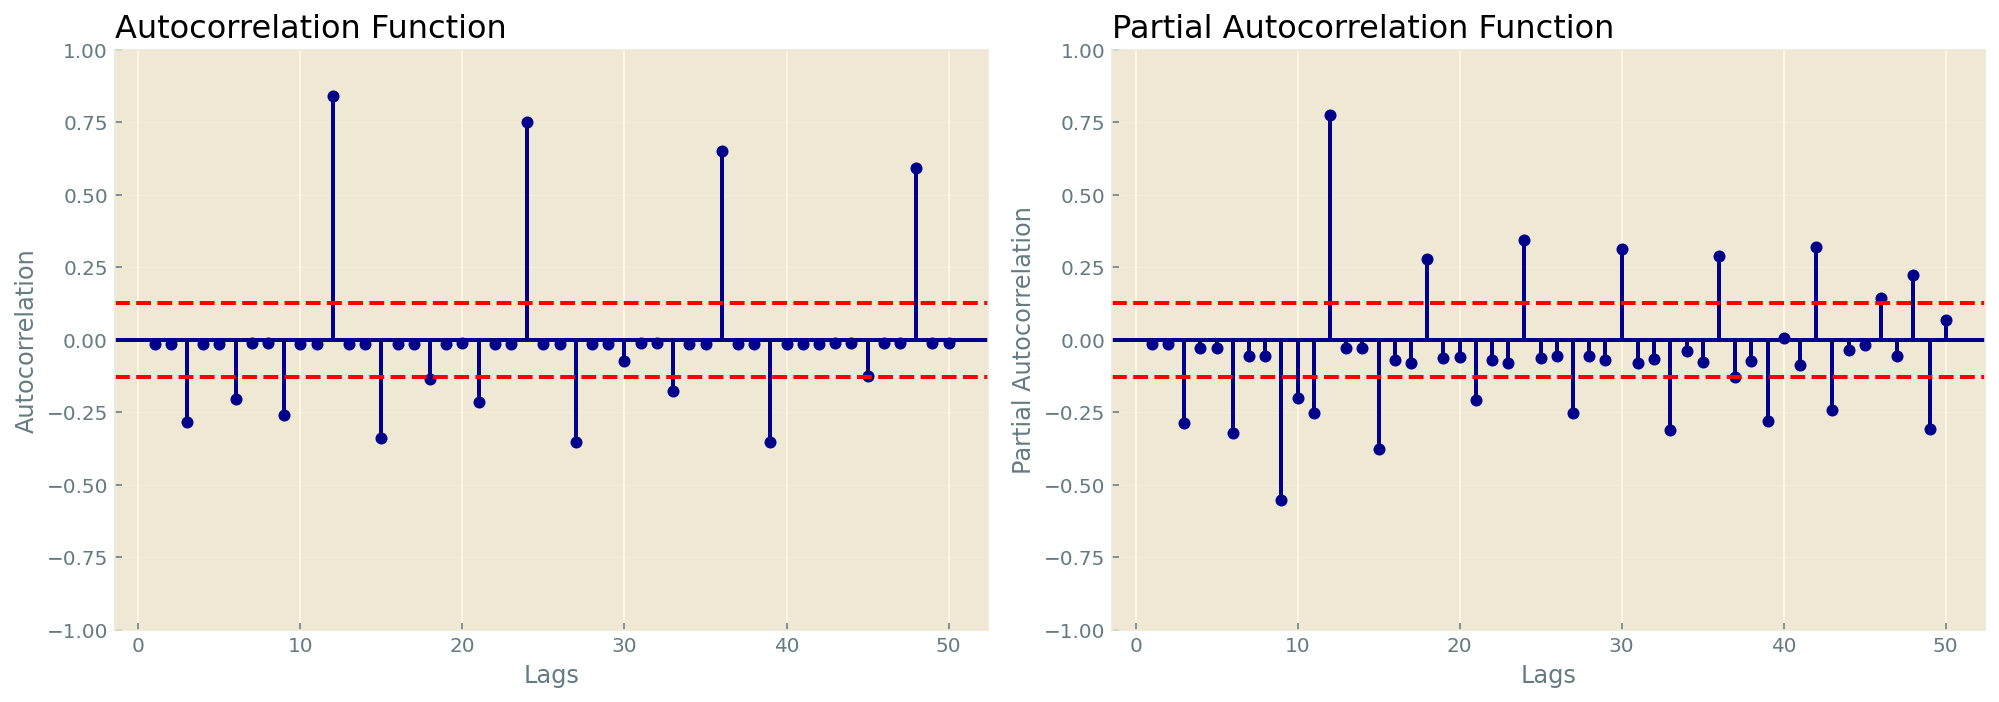

In [196]:
acf_plot(df["ICT_GDP"])

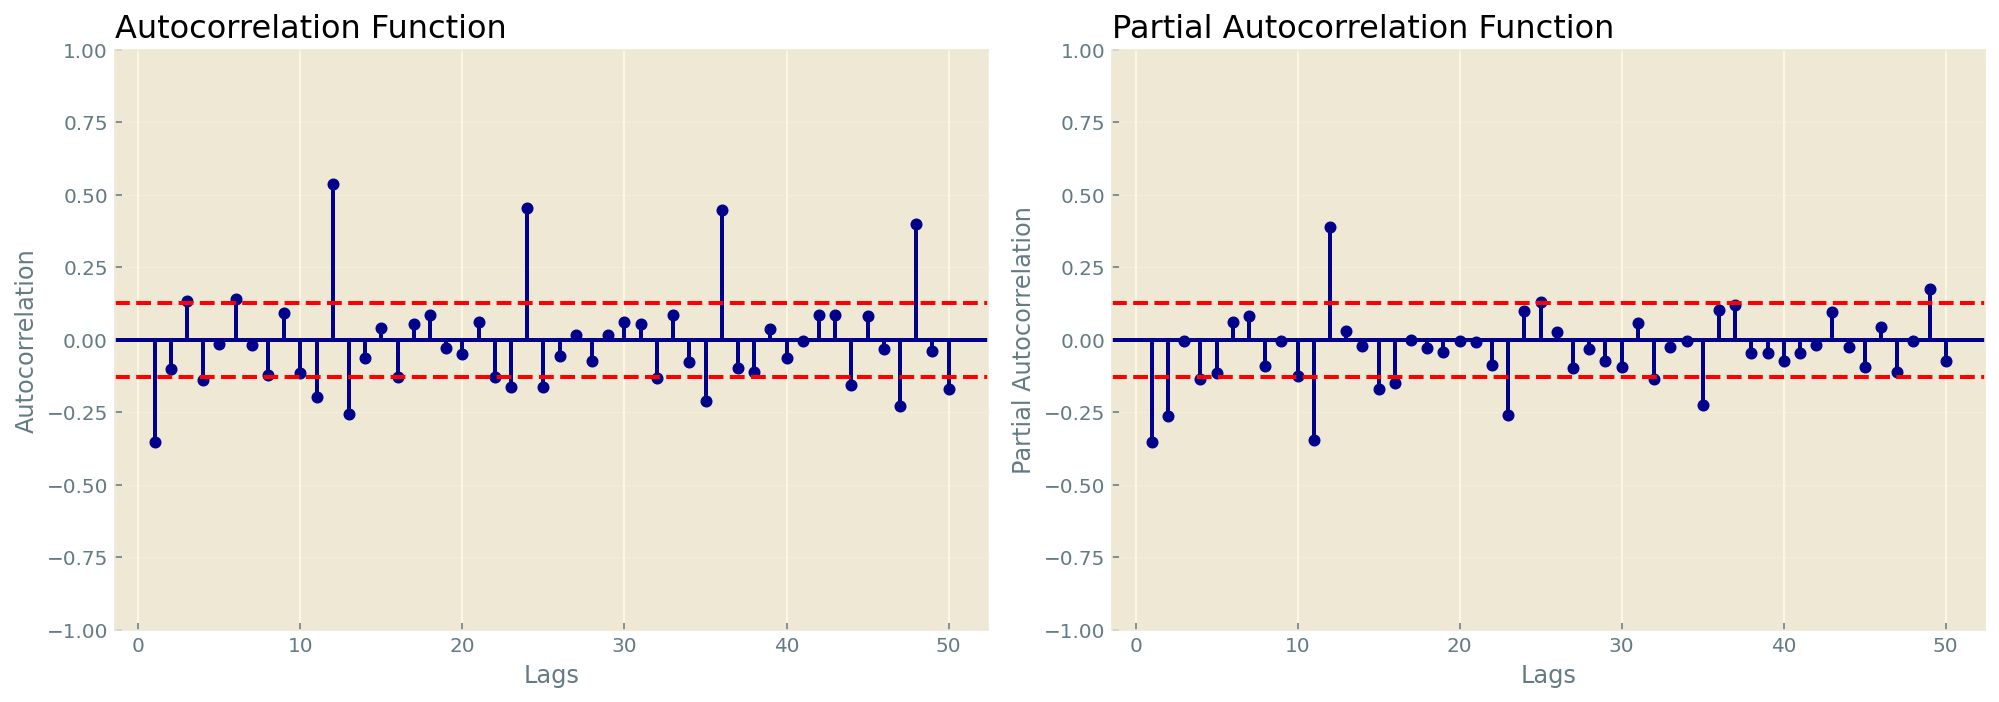

In [197]:
acf_plot(df["EXPORT"])

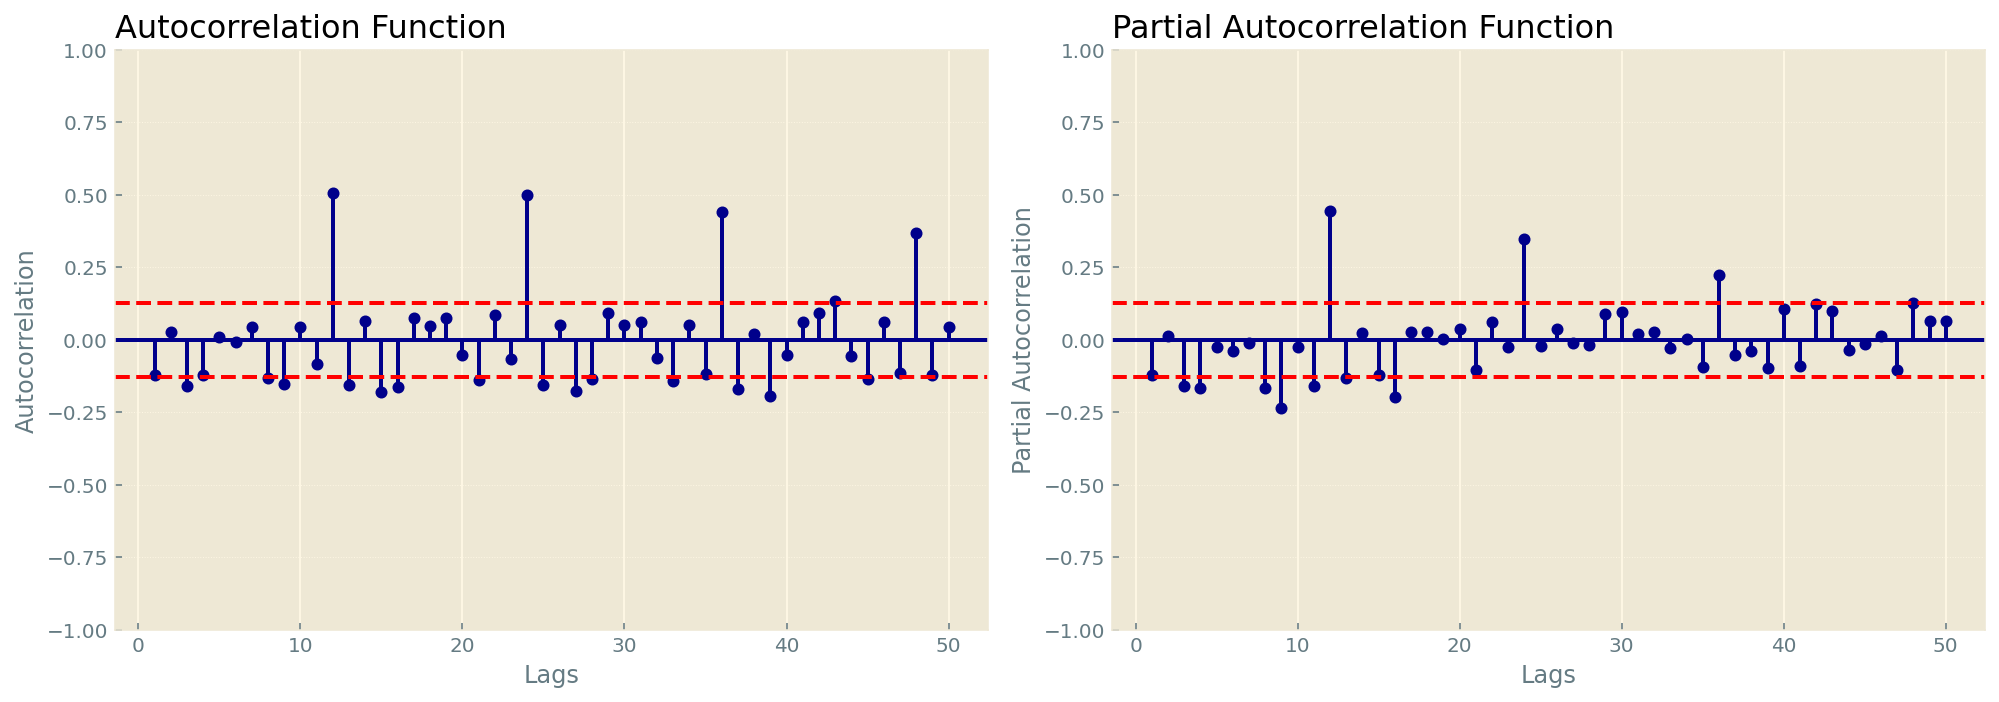

In [198]:
acf_plot(df["ICT_INDEX"])

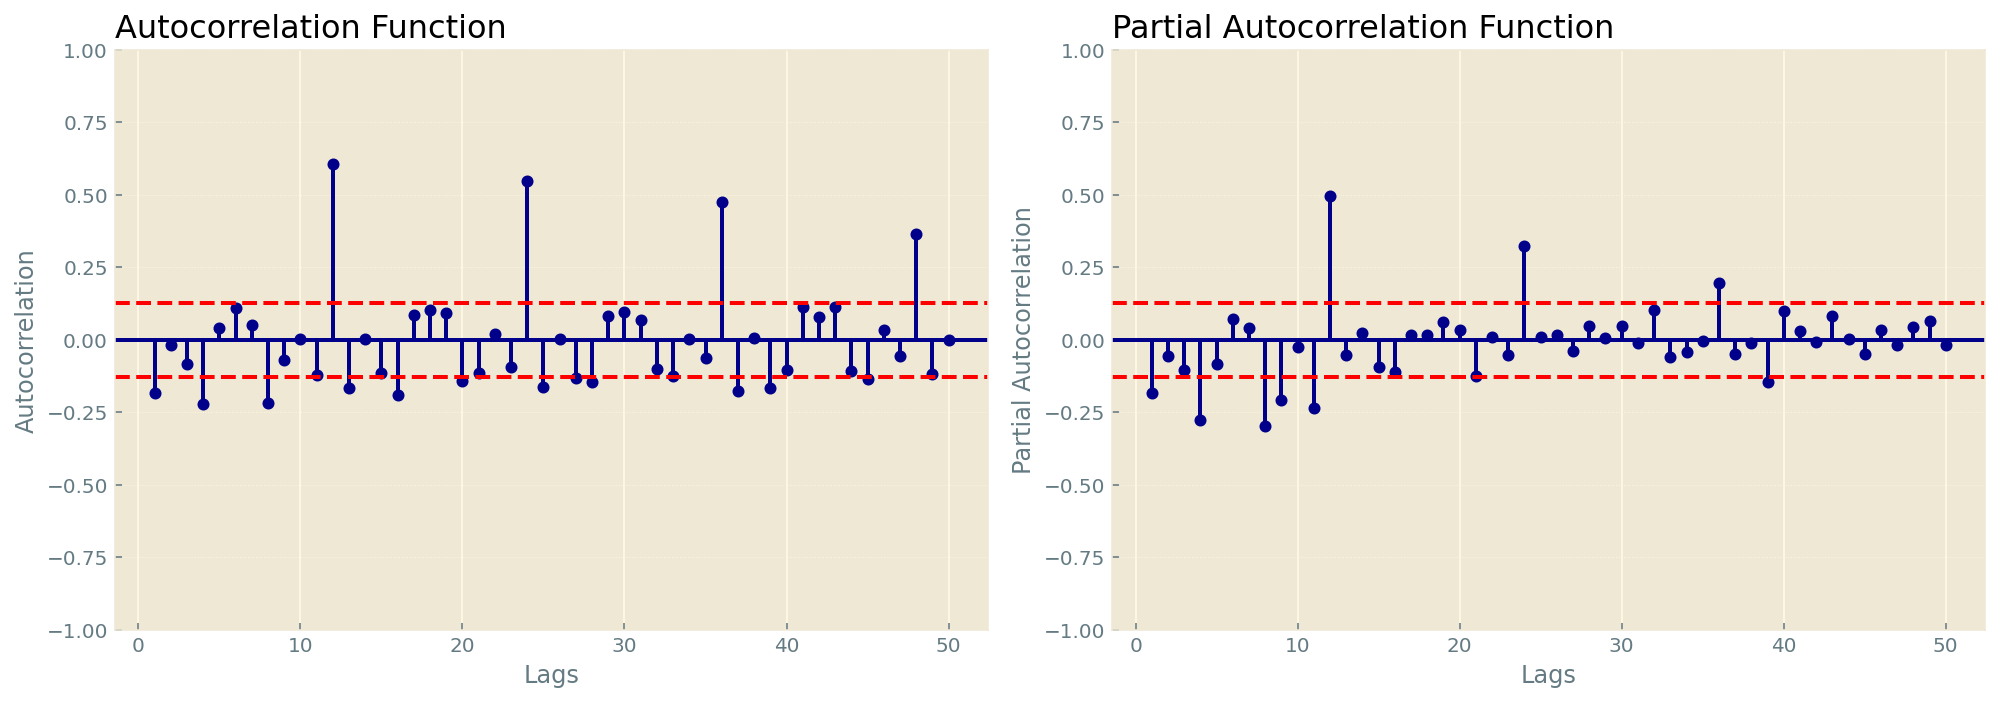

In [199]:
acf_plot(df["SHIP_INDEX"])

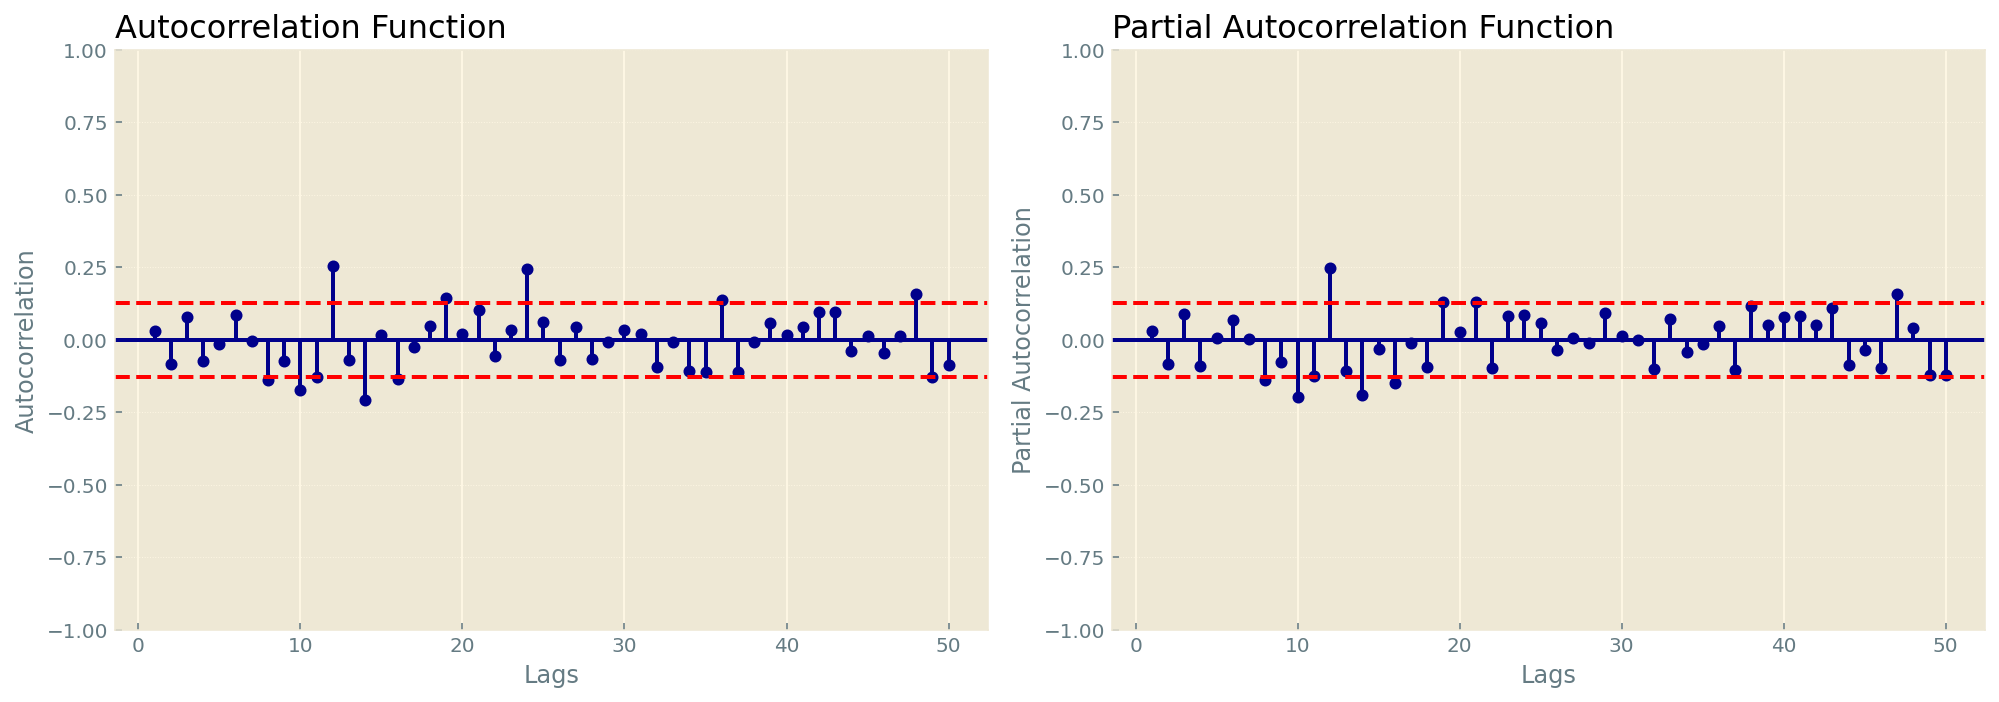

In [200]:
acf_plot(df["INVENT_INDEX"])

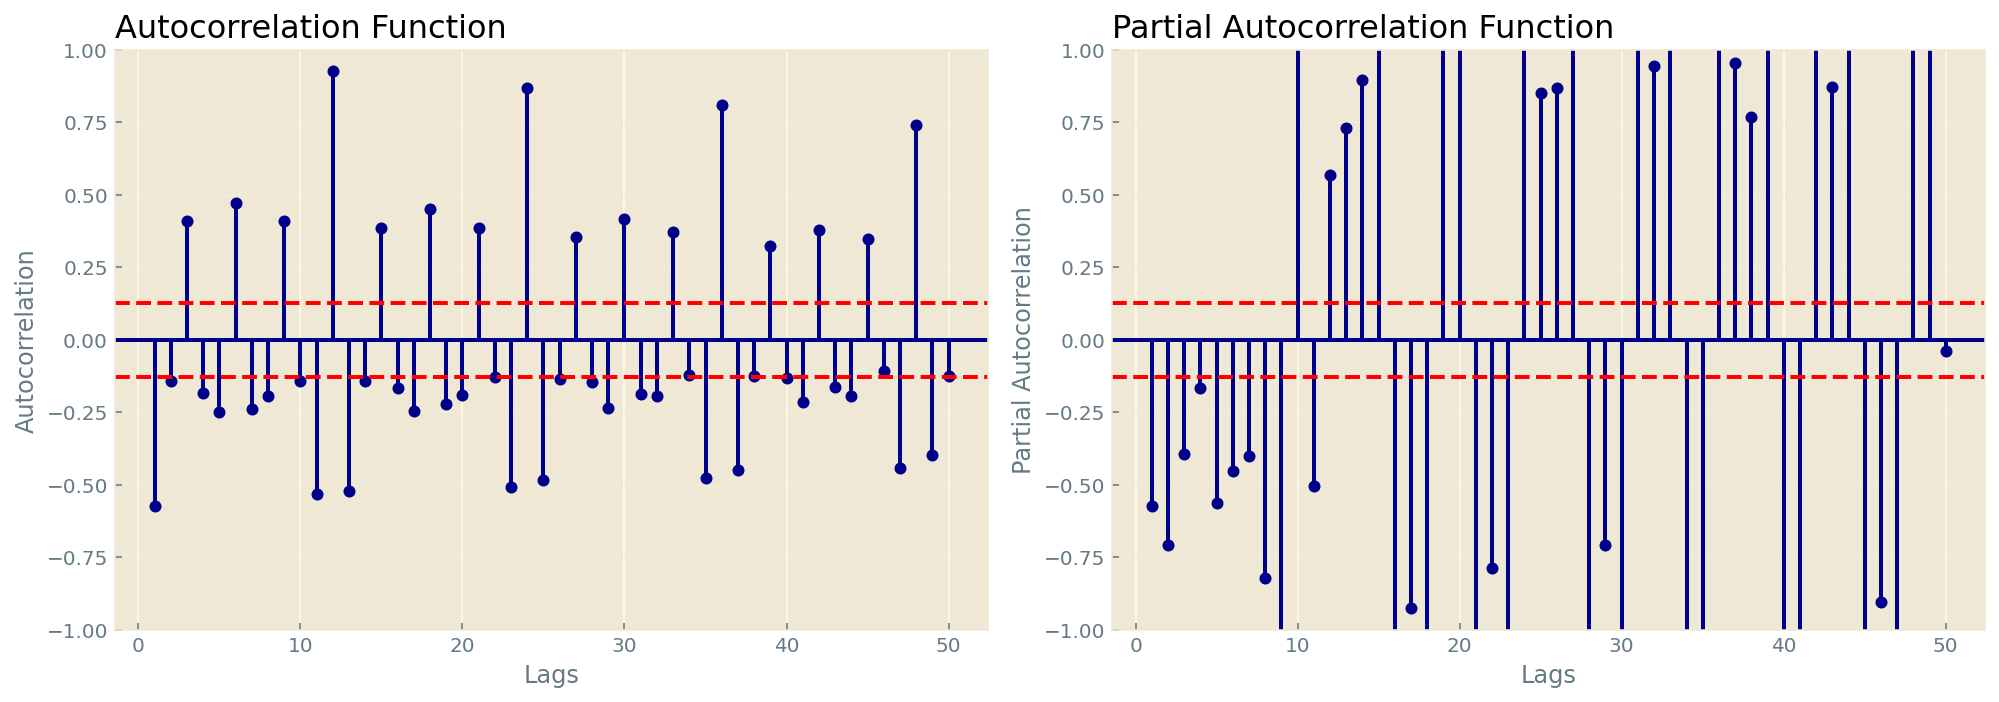

In [201]:
acf_plot(df["SERVICE"])

### Ljung-Box-Q Test

In [202]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq = acorr_ljungbox(data, lags = 100)
    test_statistic, p_value = lbq[0].mean(), lbq[1].mean()
    return test_statistic, p_value

In [203]:
# run the Ljung-Box-Q test
lbq_results = pd.DataFrame(columns = ["t-value", "p-value"], 
                       index = ["ICT_GDP", "EXPORT","ICT_INDEX", "SHIP_INDEX", "INVENT_INDEX", "SERVICE"])
for column in df:
    lbq_results.loc[column] = lbq_test(df[column])

KeyError: ignored

In [ ]:
# print results
lbq_results = lbq_results.astype(float).round(2)
print(lbq_results)

### Granger's Causality Test

In [204]:
# Granger-Causality test
# null hypothesis : past values of time-series X do not cause the other series Y
# alternate hypothesis : past values of time-series X cause the other series Y
# reject null hypothesis if p-value <= 0.05
def causality_matrix(data, variables):
    # create empty matrix
    matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)
    for c in matrix.columns:
        for r in matrix.index:
            # fill matrix with p-values for each combination of time-series
            test_result = grangercausalitytests(data[[r, c]], maxlag = 50, verbose = False)
            p_values = [test_result[i + 1][0]["ssr_ftest"][1] for i in range(50)]
            min_p_value = np.min(p_values)
            matrix.loc[r, c] = min_p_value
    matrix = matrix.astype(float).round(2)
    return matrix

In [205]:
# print results
print(causality_matrix(df, df.columns))

              ICT_GDP  EXPORT  ICT_INDEX  SHIP_INDEX  INVENT_INDEX  SERVICE
ICT_GDP           1.0     0.0        0.0         0.0           0.0      0.0
EXPORT            0.0     1.0        0.0         0.0           0.0      0.0
ICT_INDEX         0.0     0.0        1.0         0.0           0.0      0.0
SHIP_INDEX        0.0     0.0        0.0         1.0           0.0      0.0
INVENT_INDEX      0.0     0.0        0.0         0.0           1.0      0.0
SERVICE           0.0     0.0        0.0         0.0           0.0      1.0


# 3. Export and Split Data

the training data is used for model training and hyperparameter optimization and the test set is used for final evaluation and out-of-sample forecasting. For training and evaluation of the models, the Box-Jenkins approach will be followed.

In [206]:
# select 2018 and 2019 as test data
# Nate's note: should we exclude 2020 data due to Covid19?
def training_split(data):
    training = data["2000-01-01":"2017-12-31"]
    testing = data["2018-01-01":"2019-12-31"]
    return training, testing

In [207]:
names = ["training", "testing"]

In [208]:
# this is for ARIMA data
training, testing = training_split(df["ICT_GDP"])

In [209]:
# save to current working directory
for i, data in enumerate([training, testing]):
    data.to_csv(os.getcwd() + 
                "/data/Training/%s.csv" % (names[i]))

In [210]:
# this is for VAR moddel
training, testing = training_split(df)

In [211]:
# save to current working directory
for i, data in enumerate([training, testing]):
    data.to_csv(os.getcwd() + "/data/Training_var/%s.csv" % (names[i]))

# 5. Models

##  Univariate Data (ARIMA)

### 1. Load Data

In [121]:
# import all modules related to visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [122]:
# import all modules related to statistical computing
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import q_stat, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

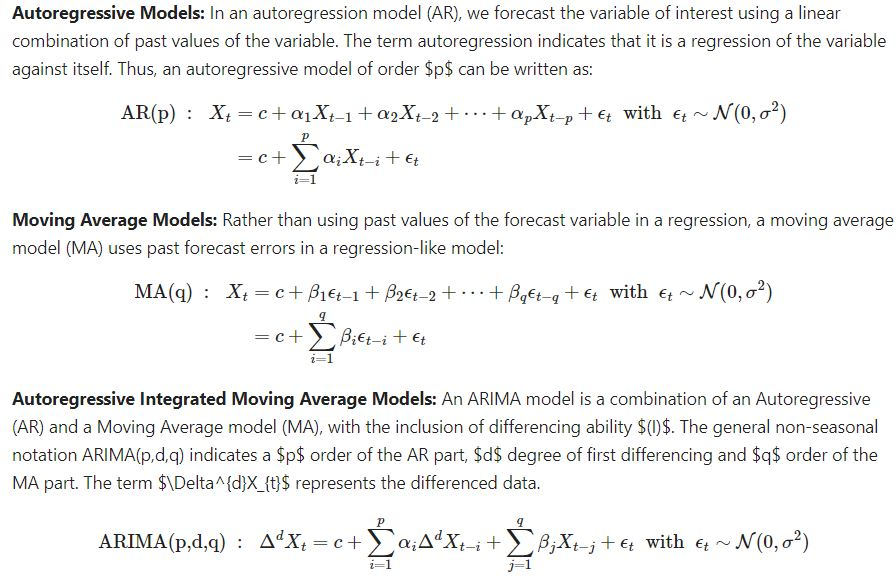

In [123]:
# read in all the csv-files
path = os.getcwd() + "/data/Training"
files = glob.glob(os.path.join(path, "*.csv"))
file_list = list()
for f in files:
    df = pd.read_csv(f)
    file_list.append(df)

# set the date as index
for i in range(len(file_list)):
    file_list[i]["Date"] = pd.to_datetime(file_list[i]["Date"])
    file_list[i].set_index("Date", inplace = True)

training, testing = [f for f in file_list]

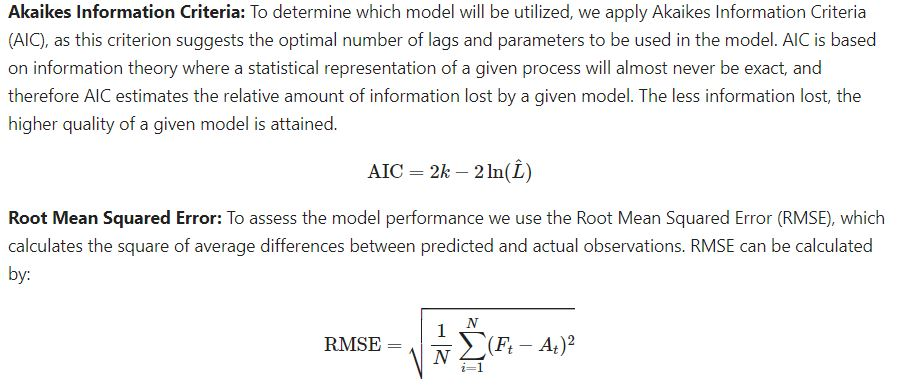

### 2. Grid Search

In [124]:
# in-sample forecast evaluation for arima models:
# 1. fit model parameters on the training sample and compute the aic
# 2. produce one-step-ahead forecasts for each value in the training sample
# 3. expand the sample to include the next observation, and repeat
# 4. compare fitted values against training sample
def evaluate_model(training, order):
    # fit model on training sample
    model = sm.tsa.ARIMA(training, order = order)
    model_fit = model.fit()
    y_hat = model_fit.fittedvalues
    # save original data and fitted values
    model_data = training.copy()
    model_data["fitted_values"] = y_hat
    # compute the rmse for the given combination of (p,d,q)
    rmse = np.sqrt(mean_squared_error(training, y_hat))
    # return the rmse, fitted values, aic score and residuals
    return model_fit.aic, rmse, model_data, model_fit.resid

In [146]:
# grid-search for finding the best combination of arima parameters (p,d,q)
def grid_search(training, p_grid, d_grid, q_grid):
    best_score, best_cfg = float("inf"), None
    aic_values = list()
    for p in p_grid:
        for q in q_grid:
            for d in d_grid:
                order = (p,d,q)
                try:
                    aic, rmse, model_data, residuals = evaluate_model(training, order)
                    if aic < best_score:
                        best_score, best_rmse, best_cfg, best_model_data, best_resid = aic, rmse, order, model_data, residuals
                    print("> ARIMA%s; AIC = %.2f" % (order, aic))
                    aic_values.append(aic)
                except:
                    continue
    # print best model and return best configuration and best scores 
    print("> best model: ARIMA%s with AIC of %.2f" % (best_cfg, best_score))
    return best_cfg, best_model_data, aic_values, best_rmse, best_resid

In [126]:
# select range of (p,d,q) parameters
p, d, q = range(0,6), range(0,1), range(0,6)

In [127]:
# run the grid-search
best_cfg, model_data, aic_values, rmse, residuals = grid_search(training, p, d, q)

> ARIMA(0, 0, 0); AIC = 1305.14
> ARIMA(0, 0, 1); AIC = 1307.02
> ARIMA(0, 0, 2); AIC = 1308.28
> ARIMA(0, 0, 3); AIC = 1266.43
> ARIMA(0, 0, 4); AIC = 1267.56
> ARIMA(0, 0, 5); AIC = 1269.35
> ARIMA(1, 0, 0); AIC = 1307.02
> ARIMA(1, 0, 1); AIC = 1283.51
> ARIMA(1, 0, 2); AIC = 1283.05
> ARIMA(1, 0, 3); AIC = 1267.50
> ARIMA(1, 0, 4); AIC = 1269.42
> ARIMA(1, 0, 5); AIC = 1271.33
> ARIMA(2, 0, 0); AIC = 1308.91
> ARIMA(2, 0, 1); AIC = 1281.82
> ARIMA(2, 0, 2); AIC = 1268.67
> ARIMA(2, 0, 3); AIC = 1269.37
> ARIMA(2, 0, 4); AIC = 1268.55
> ARIMA(2, 0, 5); AIC = 1246.27
> ARIMA(3, 0, 0); AIC = 1285.45
> ARIMA(3, 0, 1); AIC = 1276.55
> ARIMA(3, 0, 2); AIC = 1255.70
> ARIMA(3, 0, 3); AIC = 1263.02
> ARIMA(3, 0, 4); AIC = 1255.56
> ARIMA(3, 0, 5); AIC = 1235.94
> ARIMA(4, 0, 0); AIC = 1286.99
> ARIMA(4, 0, 1); AIC = 1272.31
> ARIMA(4, 0, 2); AIC = 1257.63
> ARIMA(4, 0, 3); AIC = 1253.93
> ARIMA(4, 0, 4); AIC = 1249.07
> ARIMA(4, 0, 5); AIC = 1244.65
> ARIMA(5, 0, 0); AIC = 1288.51
> ARIMA(

### 3. Plot Model

In [128]:
# function for visualization of model training and the corresponding aic
def plot_model(model_data, aic, rmse):
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1], width_ratios = [3, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # plot actual and fitted values
    ax1.plot(model_data.iloc[:,0], color = "darkblue", label = "Actual")
    ax1.plot(model_data.iloc[:,1], color = "red", label = "Fitted", linestyle = "-")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP Growth")
    ax1.set_title("Fitted Values for best ARIMA Combination (RMSE = %.2f)" % (rmse), loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)

    ax2 = plt.subplot(gs[0, 1])
    # plot aic values
    ax2.plot(aic, color = "green")
    ax2.set_xlabel("Grid-Search Iteration")
    ax2.set_ylabel("AIC Value")
    ax2.set_title("Corresponding AIC", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values (yearly average)
    ax3.plot(model_data.iloc[:,0].resample("Y").mean(), color = "darkblue", 
             label = "Actual")
    ax3.plot(model_data.iloc[:,1].resample("Y").mean(), color = "red", 
             label = "Fitted", linestyle = "-")
    ax3.set_title("Fitted Values (Yearly Average)", loc = "left")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Real GDP Growth")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax3.legend(frameon = False)
    
    # layout optimization
    plt.tight_layout()

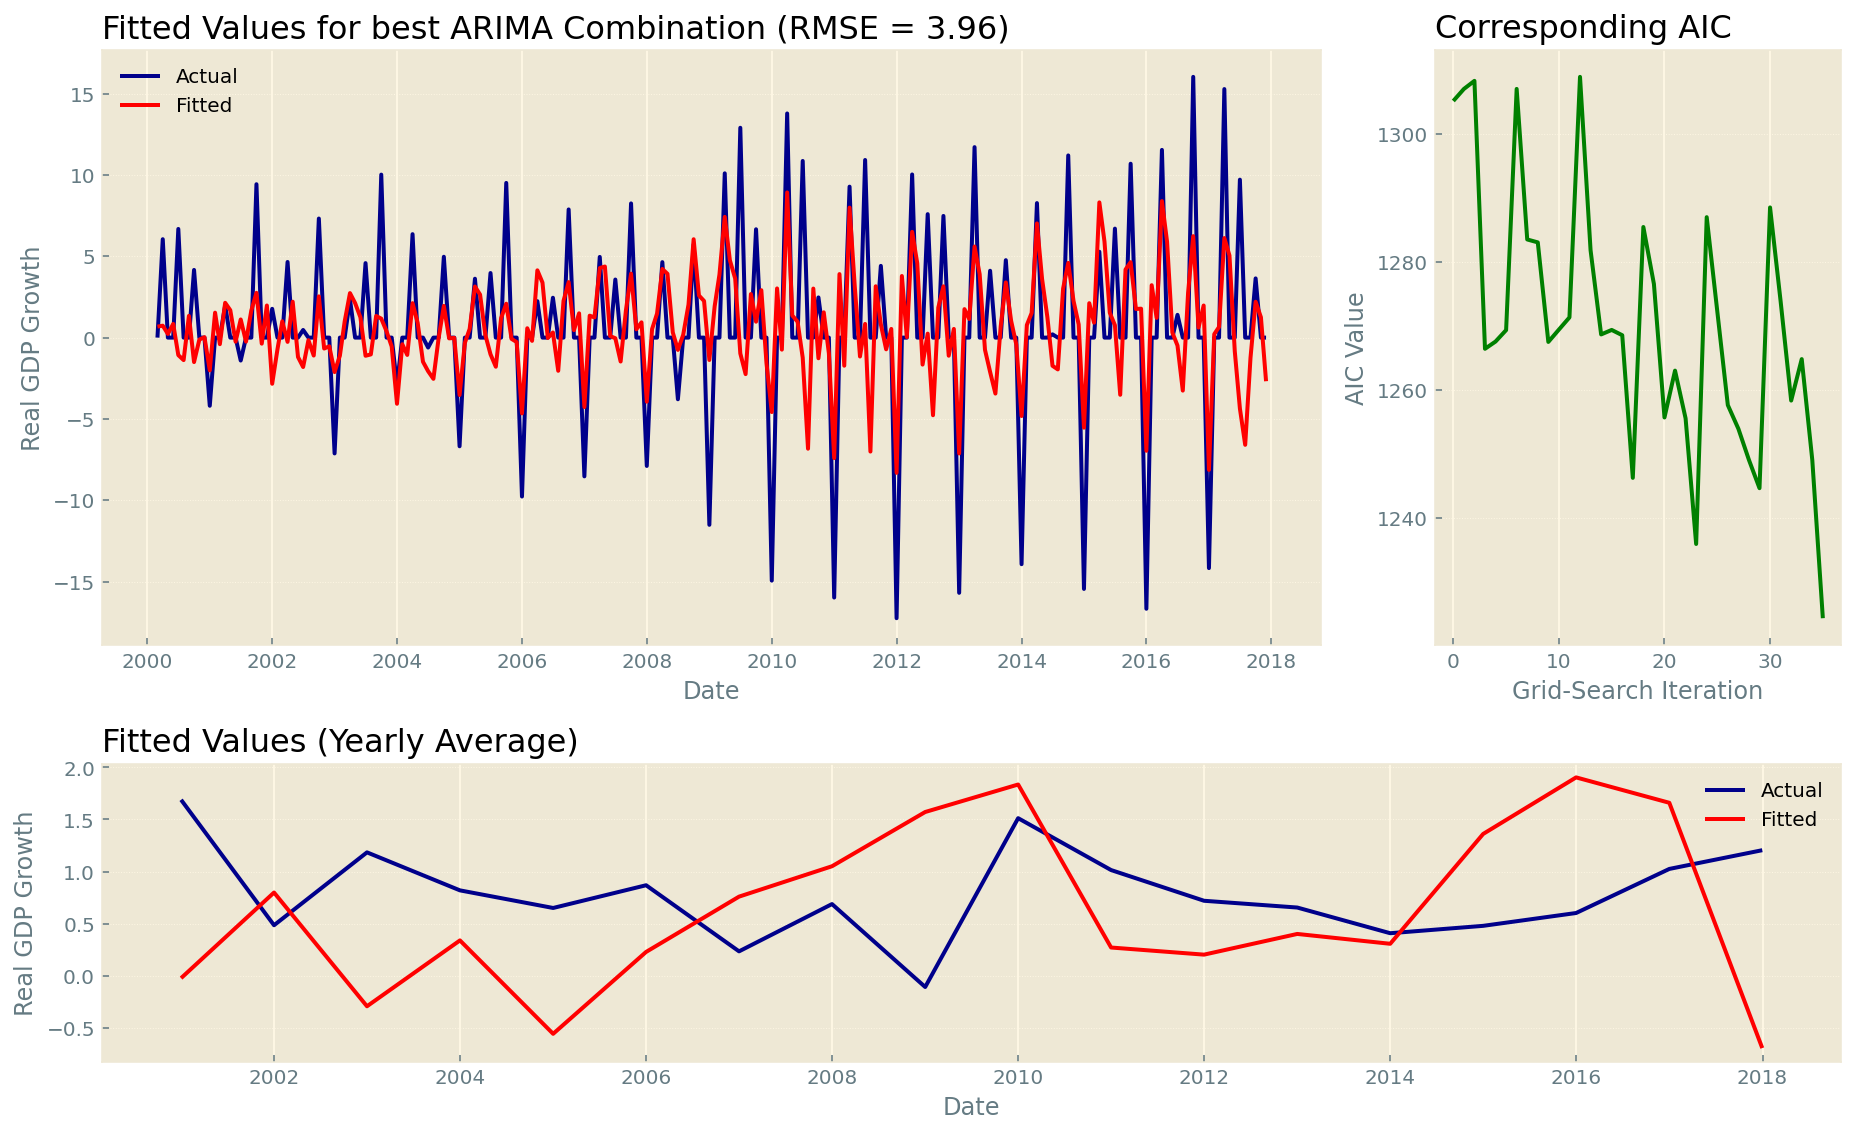

In [129]:
# visualize the model training
plot_model(model_data, aic_values, rmse)

### 4. Plot residual

In [130]:
# good forecasting methods will yield residuals with the following properties:
# 1. The residuals are uncorrelated (otherwise there is information left)
# 2. The residuals have zero mean (otherwise the forecasts are biased)
# 3. The residuals have constant variance (useful, but not necessary)
# 4. The residuals are normally distributed (useful, but not necessary)
def plot_residuals(data):   
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # distribution plot
    residuals.plot(kind = "density", ax = ax1, color = "darkblue", legend = False)
    ax1.set_title("Density of Residuals", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # normal distribution
    mean, std = stats.norm.fit(residuals)
    x = np.linspace(-8, 8, 300)
    p = stats.norm.pdf(x, mean, std)
    ax1.plot(x, p, "green")
    ax1.legend(["Residuals", "Normal"], frameon = False)
    ax1.axvline(x = 0, color = "red", linestyle = "--")

    ax2 = plt.subplot(gs[0, 1])
    # compute the autocorrelation coefficients of the residuals and plot them
    plot_acf(residuals, ax = ax2, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.axhline(y = 2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function of Residuals", loc = "left")
    ax2.set_ylim(-0.25, 0.25)
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values on yearly average
    ax3.plot(residuals, color = "darkblue")
    ax3.axhline(y = 0, color = "red", linestyle = "--")
    ax3.set_title("Residuals", loc = "left")
    ax3.set_xlabel("Date")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # layout optimization
    plt.tight_layout()

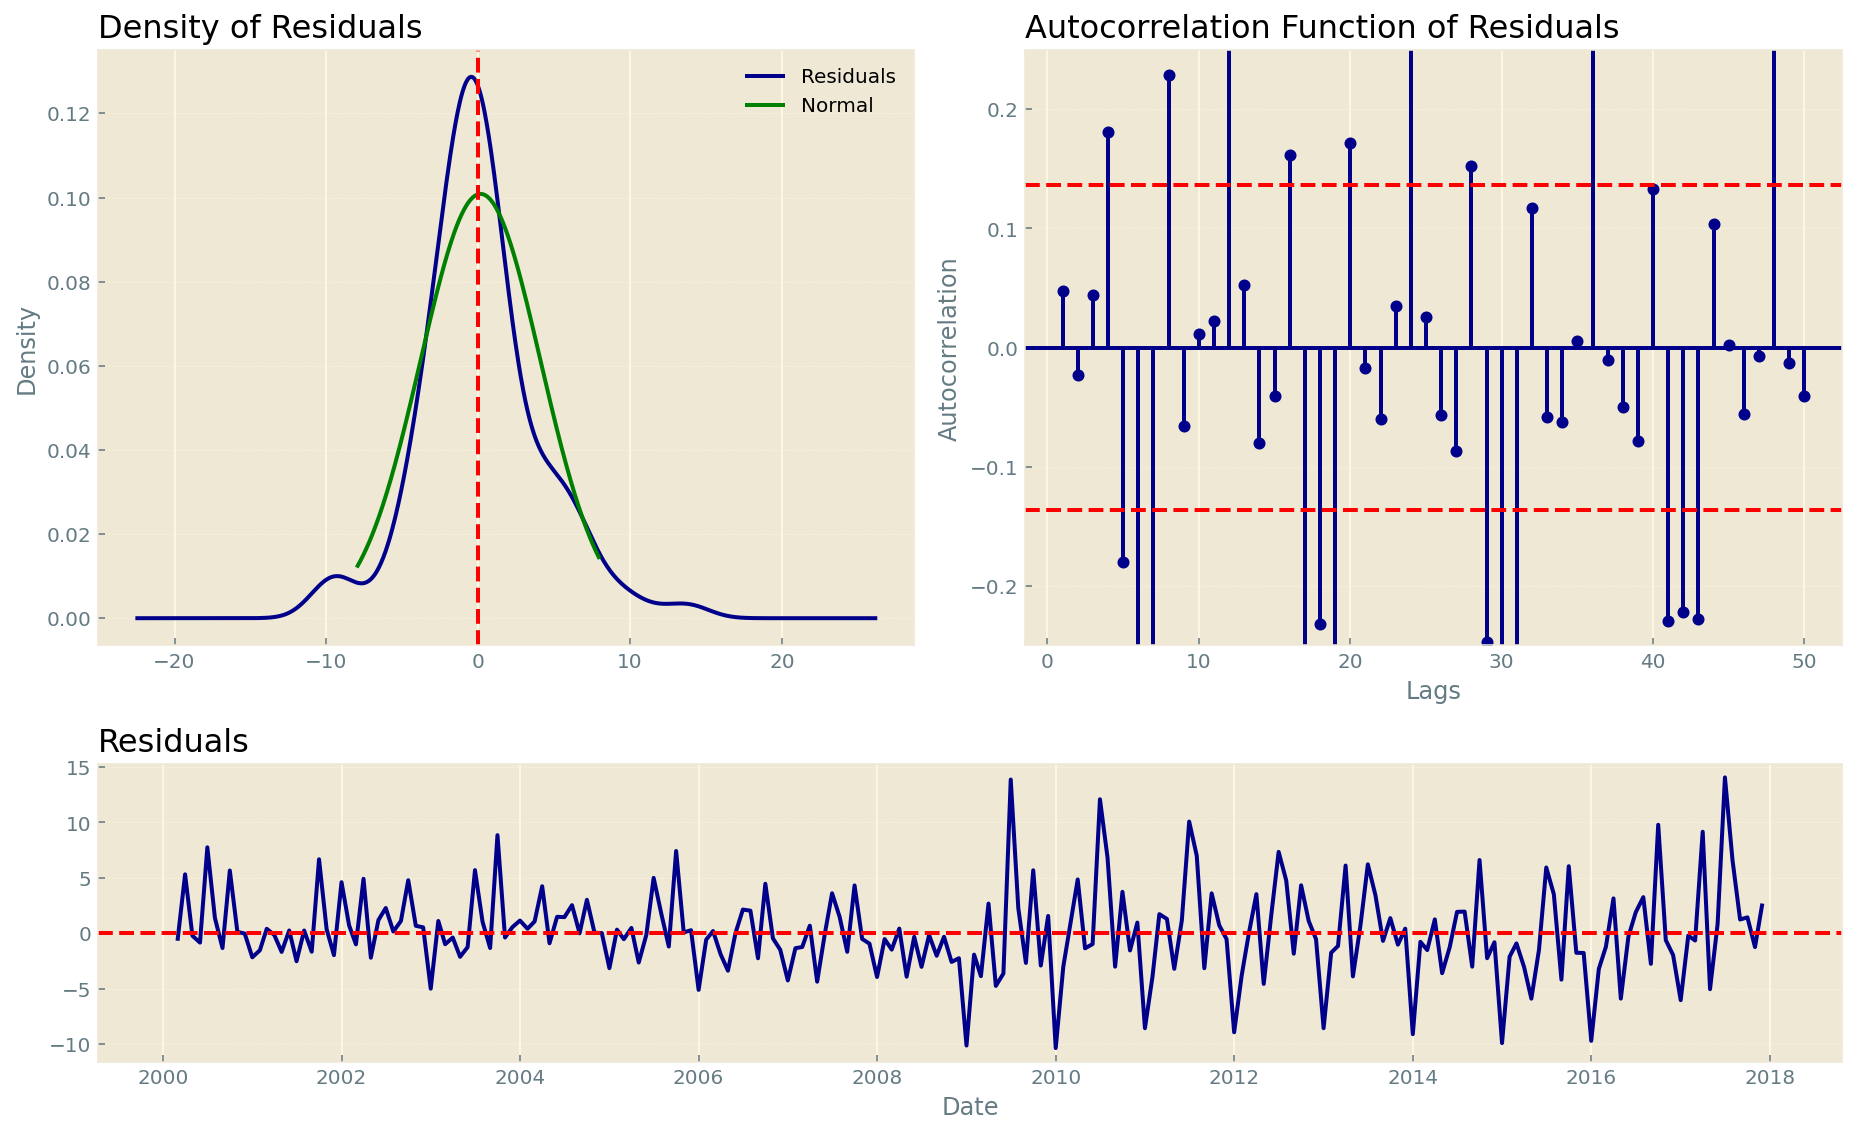

In [131]:
# residuals for chosen parameter combination on full training data
plot_residuals(residuals)

### 5. Heteroskedasticity test

In [132]:
# Goldfeld-Quandt Test for Heteroskedasticity

# source code from statsmodels for Goldfeld-Quandt test
def heteroskedasticity_test(resid):
    squared_resid = np.asarray(resid, dtype = float) ** 2
    if squared_resid.ndim == 1:
        squared_resid = squared_resid.reshape(-1, 1)
    nobs = len(resid)

    h = int(np.round(nobs * 1/3))

    numer_resid = squared_resid[-h:]
    numer_dof = (~np.isnan(numer_resid)).sum(axis = 0)
    numer_squared_sum = np.nansum(numer_resid, axis = 0)

    denom_resid = squared_resid[:h]
    denom_dof = (~np.isnan(denom_resid)).sum(axis = 0)
    denom_squared_sum = np.nansum(denom_resid, axis = 0)

    test_statistic = numer_squared_sum / denom_squared_sum

    from scipy.stats import f
    pval_lower = lambda test_statistics: f.cdf(test_statistics, numer_dof, denom_dof)
    pval_upper = lambda test_statistics: f.sf(test_statistics, numer_dof, denom_dof)
    p_value = 2 * np.minimum(pval_lower(test_statistic), pval_upper(test_statistic))

    return test_statistic, p_value

In [133]:
# Goldfeld-Quandt test
# null hypothesis : homoscedasticity of residuals (constant variance)
# alternate hypothesis : heteroscedasticity of residuals (variance not constant)
# reject null hypothesis if p-value <= 0.05
def gq_test(data):
    gq_test = heteroskedasticity_test(data)
    test_statistic, p_value = gq_test[0], gq_test[1]
    print("> goldfeld-quandt test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))

In [134]:
gq_test(residuals)

> goldfeld-quandt test results:
> test statistic = 2.42
> p-value = 0.00


In [135]:
lbq_test(residuals)

KeyError: ignored

In [136]:
# Jarque-Bera Test for Normality
# Jarque-Bera test
# null hypothesis : data is normally distributed
# alternate hypothesis : data is not normally distributed
# reject null hypothesis if p-value <= 0.05
def jb_test(data):
    jb_test = jarque_bera(data)
    test_statistic, p_value, skew, kurtosis = jb_test[0], jb_test[1], jb_test[2], jb_test[3]
    print("> jarque-bera test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))
    print("> estimated skew = %.2f" % (skew))
    print("> estimated kurtosis = %.2f" % (kurtosis))

In [137]:
jb_test(residuals)

> jarque-bera test results:
> test statistic = 27.81
> p-value = 0.00
> estimated skew = 0.44
> estimated kurtosis = 4.54


### 6. Forecasting

In [139]:
# Forecast
history = [x for x in training.values]
predictions = list()
ci_lower = list()
ci_upper = list()
# walk-forward validation
for t in range(len(testing.values)):
    #model = sm.tsa.ARIMA(history, order = best_cfg)
    model = sm.tsa.ARIMA(history, order = best_cfg)
    model_fit = model.fit()
    # compute forecast with 80% confidence interval
    # statsmodels.tsa.arima.model.ARIMAResults.
    #y_hat = model_fit.get_forecast().summary_frame(alpha = 0.2)
    y_hat = model_fit.get_forecast().summary_frame(alpha = 0.2)
    predictions.append(y_hat["mean"][0])
    ci_lower.append(y_hat["mean_ci_lower"][0])
    ci_upper.append(y_hat["mean_ci_upper"][0])
    history.append(np.asarray([y_hat["mean"][0]]))
    date = str.split(str(testing.index[t]))[0]
    print("> (%s) forecasted = %.2f; actual = %.2f" % (date, y_hat["mean"][0], testing.values[t]))
# evaluate forecasts using rmse
rmse = np.sqrt(mean_squared_error(testing.values, predictions))
# save original data and predicted values
forecast_data = testing.copy()
forecast_data["prediction"] = predictions
forecast_data["mean_ci_lower"] = ci_lower
forecast_data["mean_ci_upper"] = ci_upper

> (2018-01-01) forecasted = -7.49; actual = -17.94
> (2018-02-01) forecasted = -2.73; actual = 0.00
> (2018-03-01) forecasted = -0.51; actual = 0.00
> (2018-04-01) forecasted = 6.10; actual = 18.24
> (2018-05-01) forecasted = 2.79; actual = 0.00
> (2018-06-01) forecasted = -2.18; actual = 0.00
> (2018-07-01) forecasted = -3.89; actual = 10.71
> (2018-08-01) forecasted = -3.95; actual = 0.00
> (2018-09-01) forecasted = 3.20; actual = 0.00
> (2018-10-01) forecasted = 4.72; actual = -9.63
> (2018-11-01) forecasted = 3.73; actual = 0.00
> (2018-12-01) forecasted = -0.96; actual = 0.00
> (2019-01-01) forecasted = -5.21; actual = -20.02
> (2019-02-01) forecasted = -1.73; actual = 0.00
> (2019-03-01) forecasted = 1.87; actual = 0.00
> (2019-04-01) forecasted = 5.82; actual = 16.00
> (2019-05-01) forecasted = 3.96; actual = 0.00
> (2019-06-01) forecasted = -1.56; actual = 0.00
> (2019-07-01) forecasted = -3.60; actual = 6.56
> (2019-08-01) forecasted = -3.11; actual = 0.00
> (2019-09-01) forec

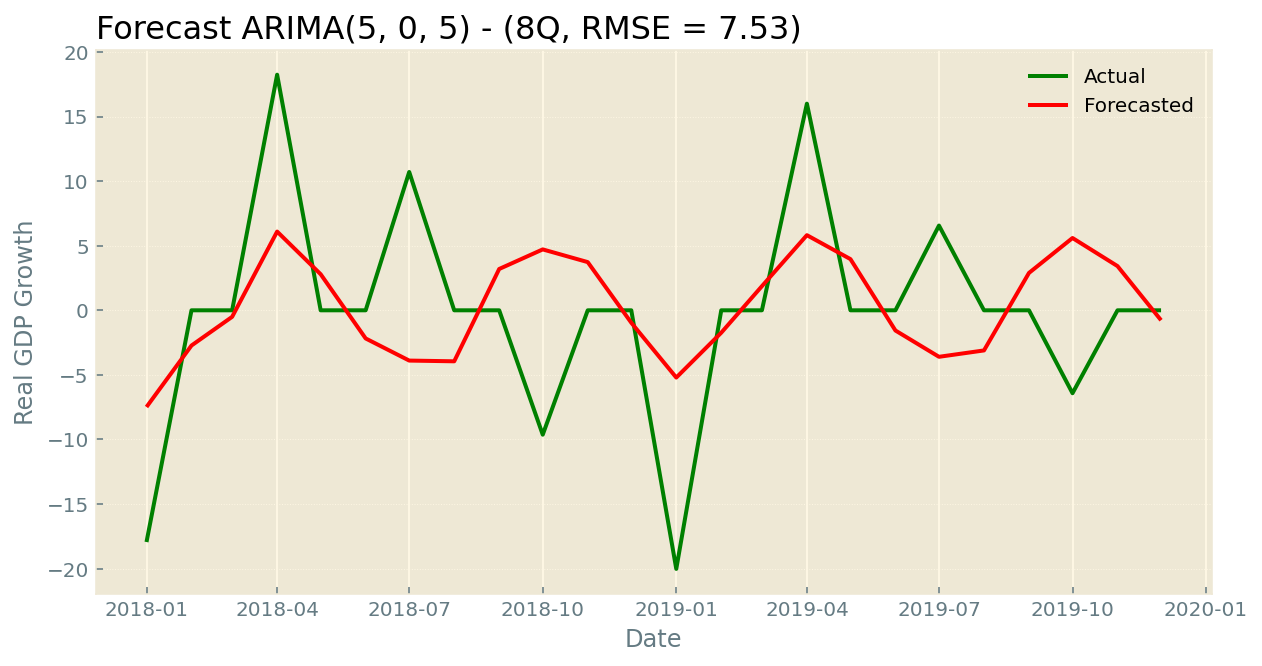

In [140]:
plt.figure(figsize = (10,5))
plt.plot(forecast_data.iloc[:,0], color = "green", label = "Actual")
plt.plot(forecast_data.iloc[:,1], color = "red", label = "Forecasted")
# plt.fill_between(forecast_data.index, forecast_data["mean_ci_lower"], forecast_data["mean_ci_upper"], 
#                 color = "k", alpha = 0.1, label = r"CI ($\alpha = 0.2$)")
plt.xlabel("Date")
plt.ylabel("Real GDP Growth")
plt.title("Forecast ARIMA%s - (8Q, RMSE = %.2f)" % (best_cfg, rmse), loc = "left")
plt.tick_params(direction = "in")
plt.grid(axis = "y", linewidth = 0.5, linestyle = ":")
plt.legend(frameon = False)
plt.show()

## Multivariate Data (VAR & RandomForest)

### 1. Load Data

In [168]:
# select 2018 and 2019 as test data
# Nate's note: should we exclude 2020 data due to Covid19?
def training_split(data):
    training = data["2000-01-01":"2017-12-31"]
    testing = data["2018-01-01":"2019-12-31"]
    return training, testing

In [169]:
names = ["training", "testing"]

In [170]:
training, testing = training_split(df)

In [171]:
# save to current working directory
for i, data in enumerate([training, testing]):
    data.to_csv(os.getcwd() + "/data/Training_var/%s.csv" % (names[i]))

In [212]:
# read in all the csv-files
path = os.getcwd() + "/data/Training_var"
files = glob.glob(os.path.join(path, "*.csv"))
file_list = list()
for f in files:
    df = pd.read_csv(f)
    file_list.append(df)

### 2. Grid Search

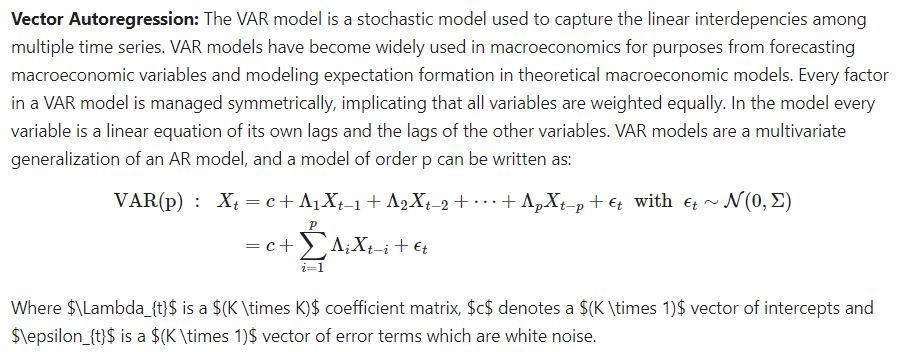

In [162]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [213]:
# in-sample forecast evaluation for var models:
# 1. fit model parameters on the training sample and compute the aic
# 2. produce one-step-ahead forecasts for each value in the training sample
# 3. expand the sample to include the next observation, and repeat
# 4. compare fitted values against training sample
def evaluate_model(training, order):
    # fit model on training sample
    model = VAR(training)
    model_fit = model.fit(order)
    y_hat = model_fit.fittedvalues
    # save original data and fitted values
    model_data = pd.DataFrame(training["ICT_GDP"].copy())
    model_data["fitted_values"] = y_hat["ICT_GDP"]
    model_data = model_data.dropna()
    # compute the rmse for the given order of p
    rmse = np.sqrt(mean_squared_error(model_data.iloc[:,0], model_data.iloc[:,1]))
    # return the rmse, fitted values, aic score and residuals
    return model_fit.aic, rmse, model_data, model_fit.resid["ICT_GDP"]

In [214]:
# grid-search for finding the best lag order p for var model
def grid_search(training, p_grid):
    best_score, best_cfg = float("inf"), None
    aic_values = list()
    for p in p_grid:
        try:
            aic, rmse, model_data, residuals = evaluate_model(training, p)
            if aic < best_score:
                best_score, best_rmse, best_cfg, best_model_data, best_resid = aic, rmse, p, model_data, residuals
            print("> VAR(%s); AIC = %.2f" % (p, aic))
            aic_values.append(aic)
        except:
            continue
    # print best model and return best configuration and best scores 
    print("> best model: VAR(%s) with AIC of %.2f" % (best_cfg, best_score))
    return best_cfg, best_model_data, aic_values, best_rmse, best_resid

In [237]:
# select range of parameters
p = range(0,25)

In [238]:
# run the grid-search
best_cfg, model_data, aic_values, rmse, residuals = grid_search(training, p)

> VAR(0); AIC = 17.24
> VAR(1); AIC = 15.57
> VAR(2); AIC = 13.88
> VAR(3); AIC = 13.11
> VAR(4); AIC = 12.98
> VAR(5); AIC = 12.94
> VAR(6); AIC = 12.72
> VAR(7); AIC = 12.61
> VAR(8); AIC = 12.09
> VAR(9); AIC = 11.93
> VAR(10); AIC = 11.72
> VAR(11); AIC = 10.85
> VAR(12); AIC = 10.87
> VAR(13); AIC = 10.99
> VAR(14); AIC = 10.99
> VAR(15); AIC = 10.85
> VAR(16); AIC = 10.84
> VAR(17); AIC = 10.79
> VAR(18); AIC = 10.93
> VAR(19); AIC = 10.92
> VAR(20); AIC = 10.66
> VAR(21); AIC = 10.60
> VAR(22); AIC = 10.35
> VAR(23); AIC = 9.67
> VAR(24); AIC = 8.96
> best model: VAR(24) with AIC of 8.96


### 3. Plot model

In [239]:
# visualization of model training and the corresponding aic
def plot_model(model_data, aic, rmse):
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1], width_ratios = [3, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # plot actual and fitted values
    ax1.plot(model_data.iloc[:,0], color = "darkblue", label = "Actual")
    ax1.plot(model_data.iloc[:,1], color = "red", label = "Fitted", linestyle = "-")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP Growth")
    ax1.set_title("Fitted Values for best VAR Model (RMSE = %.2f)" % (rmse), loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)

    ax2 = plt.subplot(gs[0, 1])
    # plot aic values
    ax2.plot(aic, color = "green")
    ax2.set_xlabel("Grid-Search Iteration")
    ax2.set_ylabel("AIC Value")
    ax2.set_title("Corresponding AIC", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values (yearly average)
    ax3.plot(model_data.iloc[:,0].resample("Y").mean(), color = "darkblue", 
             label = "Actual")
    ax3.plot(model_data.iloc[:,1].resample("Y").mean(), color = "red", 
             label = "Fitted", linestyle = "-")
    ax3.set_title("Fitted Values (Yearly Average)", loc = "left")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Real GDP Growth")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax3.legend(frameon = False)
    
    # layout optimization
    plt.tight_layout()

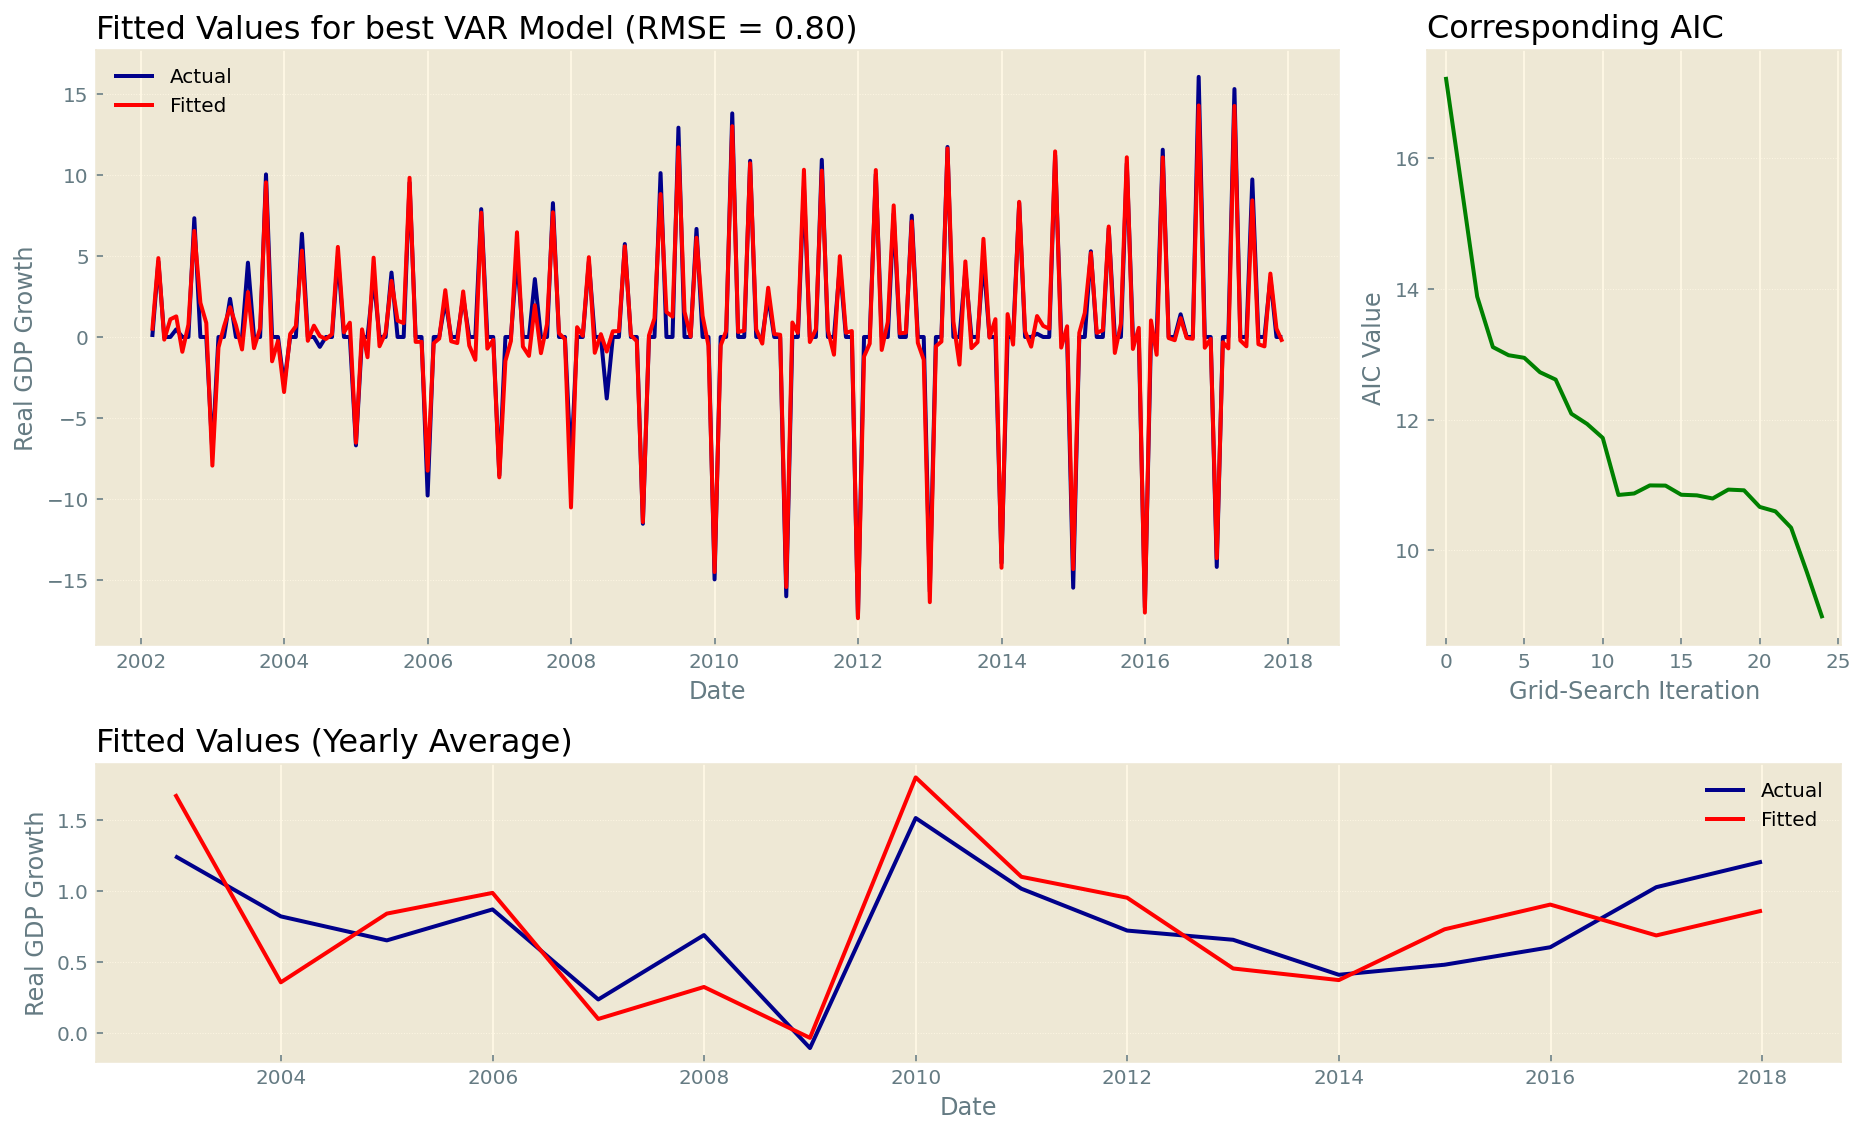

In [240]:
# visualize the model training
plot_model(model_data, aic_values, rmse)

### 4. Residuals 

In [241]:
# good forecasting methods will yield residuals with the following properties:
# 1. The residuals are uncorrelated (otherwise there is information left)
# 2. The residuals have zero mean (otherwise the forecasts are biased)
# 3. The residuals have constant variance (useful, but not necessary)
# 4. The residuals are normally distributed (useful, but not necessary)
def plot_residuals(data):   
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # distribution plot
    residuals.plot(kind = "density", ax = ax1, color = "darkblue", legend = False)
    ax1.set_title("Density of Residuals", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # normal distribution
    mean, std = stats.norm.fit(residuals)
    x = np.linspace(-8, 8, 300)
    p = stats.norm.pdf(x, mean, std)
    ax1.plot(x, p, "green")
    ax1.legend(["Residuals", "Normal"], frameon = False)
    ax1.axvline(x = 0, color = "red", linestyle = "--")

    ax2 = plt.subplot(gs[0, 1])
    # compute the autocorrelation coefficients of the residuals and plot them
    plot_acf(residuals, ax = ax2, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.axhline(y = 2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function of Residuals", loc = "left")
    ax2.set_ylim(-0.25, 0.25)
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values on yearly average
    ax3.plot(residuals, color = "darkblue")
    ax3.axhline(y = 0, color = "red", linestyle = "--")
    ax3.set_title("Residuals", loc = "left")
    ax3.set_xlabel("Date")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # layout optimization
    plt.tight_layout()

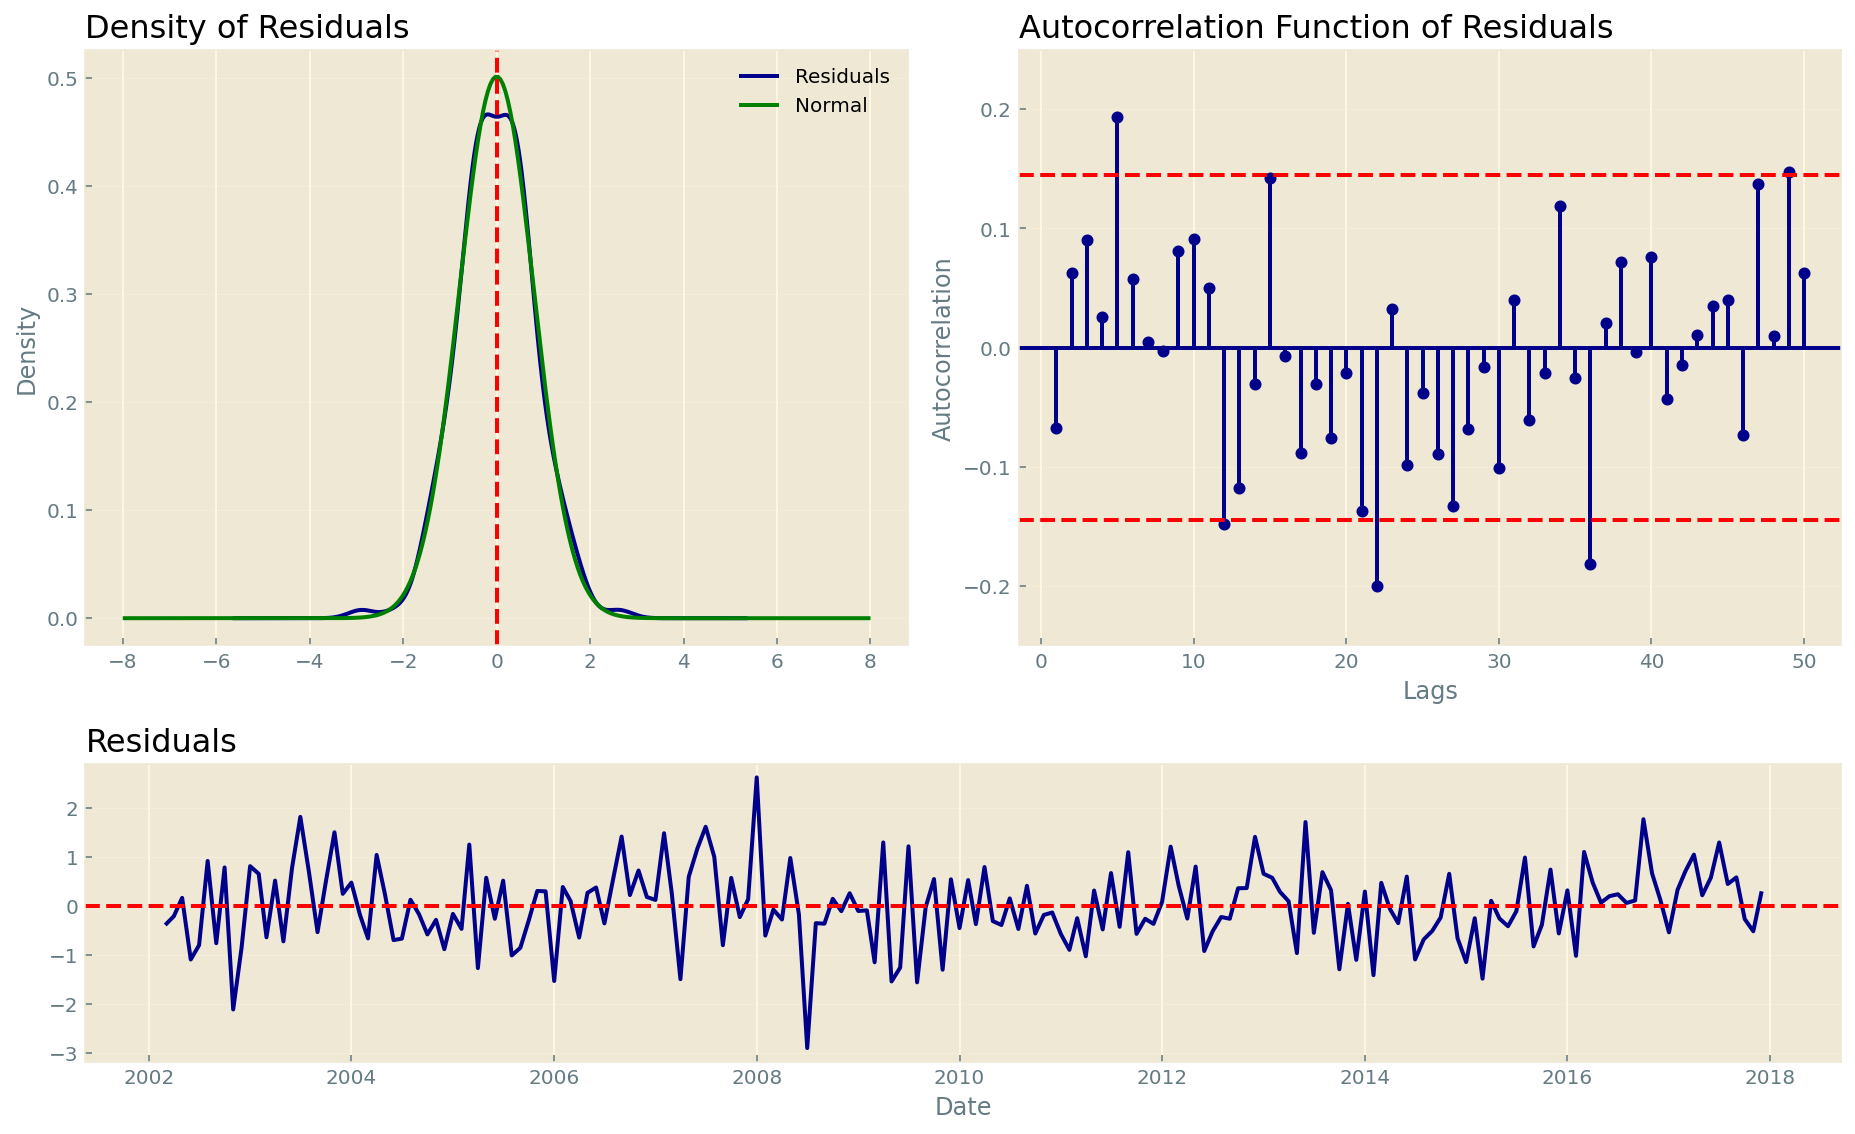

In [242]:
# residuals for chosen parameter combination on full training data
plot_residuals(residuals)

### 5. Heteroskedasticity test

In [243]:
# source code from statsmodels for Goldfeld-Quandt test
# Assumption: the variance of the error term is consistent across all measures of the model
def heteroskedasticity_test(resid):
    squared_resid = np.asarray(resid, dtype = float) ** 2
    if squared_resid.ndim == 1:
        squared_resid = squared_resid.reshape(-1, 1)
    nobs = len(resid)

    h = int(np.round(nobs * 1/3))

    numer_resid = squared_resid[-h:]
    numer_dof = (~np.isnan(numer_resid)).sum(axis = 0)
    numer_squared_sum = np.nansum(numer_resid, axis = 0)

    denom_resid = squared_resid[:h]
    denom_dof = (~np.isnan(denom_resid)).sum(axis = 0)
    denom_squared_sum = np.nansum(denom_resid, axis = 0)

    test_statistic = numer_squared_sum / denom_squared_sum

    from scipy.stats import f
    pval_lower = lambda test_statistics: f.cdf(test_statistics, numer_dof, denom_dof)
    pval_upper = lambda test_statistics: f.sf(test_statistics, numer_dof, denom_dof)
    p_value = 2 * np.minimum(pval_lower(test_statistic), pval_upper(test_statistic))

    return test_statistic, p_value

In [244]:
# Goldfeld-Quandt test
# null hypothesis : homoscedasticity of residuals (constant variance)
# alternate hypothesis : heteroscedasticity of residuals (variance not constant)
# reject null hypothesis if p-value <= 0.05
def gq_test(data):
    gq_test = heteroskedasticity_test(data)
    test_statistic, p_value = gq_test[0], gq_test[1]
    print("> goldfeld-quandt test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))

In [267]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq_test = acorr_ljungbox(data)
    test_statistic, p_value = lbq_test[0].mean(), lbq_test[1].mean()
    print("> ljung-box test results:")
    print("> average test statistic = %.2f" % (test_statistic))
    print("> average p-value = %.2f" % (p_value))

In [268]:
gq_test(residuals)

> goldfeld-quandt test results:
> test statistic = 0.85
> p-value = 0.53


In [270]:
lbq_test(residuals)

KeyError: ignored

In [248]:
# Jarque-Bera test
# null hypothesis : data is normally distributed
# alternate hypothesis : data is not normally distributed
# reject null hypothesis if p-value <= 0.05
def jb_test(data):
    jb_test = jarque_bera(data)
    test_statistic, p_value, skew, kurtosis = jb_test[0], jb_test[1], jb_test[2], jb_test[3]
    print("> jarque-bera test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))
    print("> estimated skew = %.2f" % (skew))
    print("> estimated kurtosis = %.2f" % (kurtosis))

In [249]:
jb_test(residuals)

> jarque-bera test results:
> test statistic = 3.50
> p-value = 0.17
> estimated skew = -0.05
> estimated kurtosis = 3.66


### 6. Forecasting (out-of-sample)

In [260]:
model = VAR(training)
model_fit = model.fit(best_cfg)
forecast_input = training.values[-best_cfg:]
forecast_data = model_fit.forecast_interval(forecast_input, len(testing), alpha = 0.2)
y_hat = forecast_data[0]
ci_lower = forecast_data[1]
ci_upper = forecast_data[2]
y_hat = pd.DataFrame(y_hat, index = testing.index[-best_cfg:], columns = testing.columns)
ci_lower = pd.DataFrame(ci_lower, index = testing.index[-best_cfg:], columns = testing.columns)
ci_upper = pd.DataFrame(ci_upper, index = testing.index[-best_cfg:], columns = testing.columns)
rmse = np.sqrt(mean_squared_error(testing["ICT_GDP"], y_hat["ICT_GDP"]))
for t in range(len(y_hat.values)):
    date = str.split(str(y_hat.index[t]))[0]
    print("> (%s) forecasted = %.2f; actual = %.2f" % (date, y_hat["ICT_GDP"].values[t], testing["ICT_GDP"].values[t]))


> (2018-01-01) forecasted = -14.24; actual = -17.94
> (2018-02-01) forecasted = -3.49; actual = 0.00
> (2018-03-01) forecasted = -3.30; actual = 0.00
> (2018-04-01) forecasted = 24.56; actual = 18.24
> (2018-05-01) forecasted = -3.37; actual = 0.00
> (2018-06-01) forecasted = 4.62; actual = 0.00
> (2018-07-01) forecasted = 0.62; actual = 10.71
> (2018-08-01) forecasted = 7.13; actual = 0.00
> (2018-09-01) forecasted = -5.81; actual = 0.00
> (2018-10-01) forecasted = 8.55; actual = -9.63
> (2018-11-01) forecasted = -1.93; actual = 0.00
> (2018-12-01) forecasted = 1.36; actual = 0.00
> (2019-01-01) forecasted = -18.97; actual = -20.02
> (2019-02-01) forecasted = -6.22; actual = 0.00
> (2019-03-01) forecasted = 0.44; actual = 0.00
> (2019-04-01) forecasted = 19.49; actual = 16.00
> (2019-05-01) forecasted = 3.97; actual = 0.00
> (2019-06-01) forecasted = -1.73; actual = 0.00
> (2019-07-01) forecasted = 11.06; actual = 6.56
> (2019-08-01) forecasted = -0.66; actual = 0.00
> (2019-09-01) fo

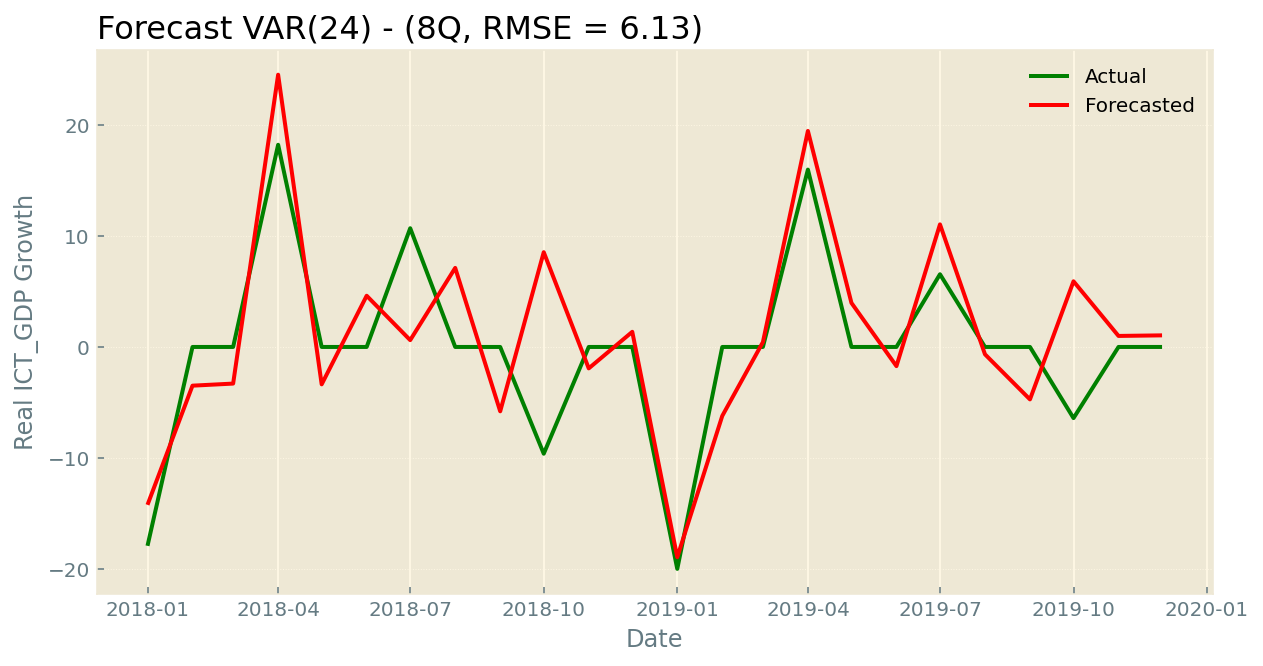

In [263]:
plt.figure(figsize = (10,5))
plt.plot(testing["ICT_GDP"], color = "green", label = "Actual")
plt.plot(y_hat["ICT_GDP"], color = "red", label = "Forecasted")
# plt.fill_between(y_hat.index, ci_lower["GDP"], ci_upper["GDP"], 
#                 color = "k", alpha = 0.1, label = r"CI ($\alpha = 0.2$)")
plt.xlabel("Date")
plt.ylabel("Real ICT_GDP Growth")
plt.title("Forecast VAR(%s) - (8Q, RMSE = %.2f)" % (best_cfg, rmse), loc = "left")
plt.tick_params(direction = "in")
plt.grid(axis = "y", linewidth = 0.5, linestyle = ":")
plt.legend(frameon = False)
plt.show()

# Print pdf

In [273]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [279]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [283]:
ls

code/  data/  ICT_TimeSeries_Kang.ipynb  login.txt  output/


In [282]:
%cd drive/My Drive/Research

[Errno 2] No such file or directory: 'drive/My Drive/Research/'
/content/drive/My Drive/Research


In [285]:
# print the output as pdf
!jupyter nbconvert --to PDF "ICT_TimeSeries_Kang.ipynb"

[NbConvertApp] Converting notebook ICT_TimeSeries_Kang.ipynb to PDF
[NbConvertApp] Support files will be in ICT_TimeSeries_Kang_files/
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making directory ./ICT_TimeSeries_Kang_files
[NbConvertApp] Making dir